In [1]:
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import scipy.io
import myTensorfunctions as mtf
from timeit import default_timer as timer
from scipy import signal
import myCumulantfunctions as mc
from tensorly.decomposition import parafac
from tensorly.decomposition import SymmetricCP
import sys
import seaborn as sns
import sympy as sp
import matplotlib.ticker as ticker
from matplotlib import rc


The code below is used to plot the diagonal values of matrix during the QR-algorithm.

In [ ]:
# Plot QR algorithm diagonal values
np.random.seed(0)
P = 5

M = np.random.randn(P,P); M = M.T @ M
print(M)
diagvals = np.diag(M)

for i in range(10):
    Q,R = sc.linalg.qr(M)
    diagvals = np.c_[diagvals,np.diag(M)]
    M = R @ Q

print(M)

plt.figure(figsize=[P*3-1,3])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

## plot for p2 = 1
for p in range(1,P+1):
    plt.subplot(1,P,p)
    if p == 2:
        plt.ylim([5.5,15])
    plt.plot(diagvals[:,1::][p-1,:],linewidth=3,color=colors[p-1])
    plt.tight_layout(pad=1)
    plt.grid('on')
    plt.xticks(np.array([*range(0,10)]))
    plt.xlim([0,10])
    plt.ylabel('$|d_{%i}|$' % p,fontsize=18,rotation=0,labelpad=20)
    plt.xlabel('Iteration $k$',fontsize=16)

The code below can be used to produce an instance of the artificial test-set. Use P to get the amount of mixtures. For P>=4 the number of latent source components will always be 4.

In [8]:
# Generate testdata
P = 4
R = P
I = 10000
noise_factor = 0.15
start_end = [0,10]

np.random.seed(0)

X,S,_,Noise = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)
S_backup = np.copy(S)

# Whiten data SVD
lam0,U00,Z = mc.SVDinit(X,P,removemean=True)
Z_backup = np.copy(Z)
C4t = mc.cum4tensor3(Z)
C4t_backup = np.copy(C4t)

In the following code window un-comment the function of choice to use on the testset.

In [9]:
# Settings
niter = 200; tol = 10**(-4)

# Nothing
Shat = np.copy(X)
U0 = np.eye(P)

#---------Non-iterative methods--------------
# ## Whitening
# lam0 = np.copy(lam0)
# U0 = np.copy(U00)
# Shat = np.copy(Z)

# # GEVD
# U0,lam = mc.CPD_gevd(np.copy(C4t),P)
# U0 = mc._sym_decorrelation(U0[0])

# ## HOSVD
# U0 = mc.HOSVD_iterFINAL(Z,Core_only=True)[0]
# Shat = U0.T @ Z
# lam = cum4_diagsWHITE(Z,U0)

# # I-HOSVD
# U0,lam = mc.HOSVD_iterFINAL(Z,False)
# Shat = U0.T @ np.copy(Z)
# U0 = U0

# # I-GEVD
# U0,lam = mc.CPD_gevdIMPLICIT_FINAL(np.copy(Z),P,0)
# Shat = U0[0].T @ np.copy(Z)
# print('sym CP error:',mc.CPDerror(C4t,lam,U0[0],True),'nonsym CP error:',mc.CPDerror(C4t,lam,U0,False))
# U0 = U0[0]


#---------Iterative methods--------------
# # QRT
Shat,U0,errQRT,QRT_niter = mc.QRT_FinalFAST(Z,R,U0.T,n_repeat=niter,tol=tol); U0 = U0.T
Shat = U0.T @ Z

# # # FICA
# FICA = FastICA(whiten=False,max_iter=niter,w_init=np.eye(P),tol=tol,fun='cube')
# Shat,err_FICA = FICA.fit_transform(Z.T); Shat = Shat.T
# U0 = FICA.mixing_

# # ffFICA method
# lam,U0,ffFICAniter,errffFICA,_ = symIMPCPDffWHITEFAST(np.copy(Z),np.ones(P),np.eye(P),P,niter,tol)
# # U0 = mc._sym_decorrelation(U0)
# Shat = U0.T @ np.copy(Z)

## ffIMP
# lamU0 = np.r_[lam0,np.eye(P).reshape(P*R,order='F')]
# options={'ftol': tol, 'gtol': tol,'maxfun': niter, 'maxiter': niter}
# solution = sc.optimize.minimize(mc.IMPCPDfunOPT,lamU0,args=(np.copy(Z),0,R),method='L-BFGS-B', jac = True)
# lam = np.copy(solution.x[0:R]); Ufinal = np.copy(solution.x[R::]).reshape([P,R],order='F')
# U0 = mc._sym_decorrelation(Ufinal)

# # SYmmetric CPD
# C4tZ = mc.cum4tensor3(Z)
# symCPD = SymmetricCP(R)
# symCPD.fit_transform(C4tZ)
# U0 = symCPD.decomposition_[1]
# lam = symCPD.decomposition_[0]
# Shat = U0.T @ np.copy(Z)

Use the followin code window to verify the results and to plot te mixtures, the resulting estimated source components and noise components.

Win?: 0


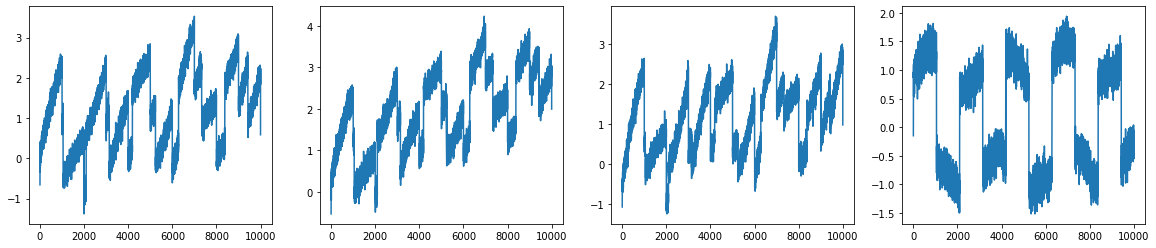

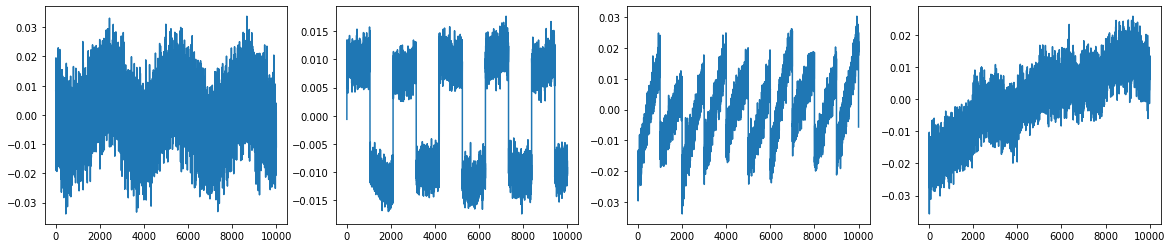

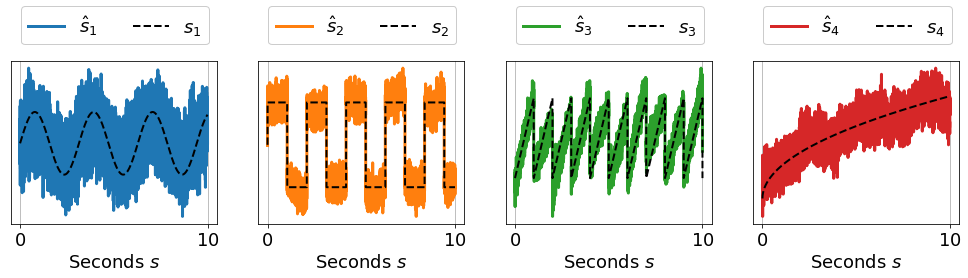

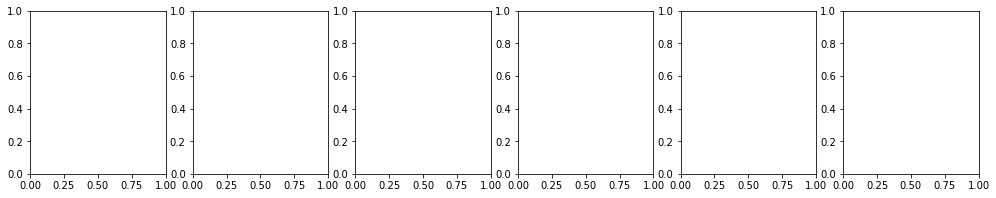

In [11]:
Shatdict = mc.Errorfunc(S,Shat)

plt.figure(figsize=[P*5,4])
for p in range(P):
    plt.subplot(1,P,p+1)
    plt.plot(X[p,:])

plt.figure(figsize=[P*5,4])
for p in range(P):
    plt.subplot(1,P,p+1)
    plt.plot(Shat[p,:])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for p in range(4):
    # S[p,:] += - np.mean(S[p,:])
    S[p,:] = S[p,:]/np.sqrt(mtf.my_inner_prod(S[p,:],S[p,:]))


# Sort in correct order
S_hatsort = np.copy(Shat)
for p,pval in enumerate(Shatdict['Finalkeys']):
    Shat[p,:] = np.copy(S_hatsort[pval,:])

Shatnoise = np.copy(S_hatsort)
for p,pval in enumerate(Shatdict['noise_comps']):
    Shatnoise[p,:] = np.copy(S_hatsort[pval,:])


fig,ax = plt.subplots(1,4,figsize=[17,3])
for p in range(S.shape[0]):
    plt.subplot(1,4,p+1)
    # plt.tight_layout(pad=-0.1)
    plt.plot(Shatdict['signs'][p]*Shat[p,:],linewidth=3,label='$\hat{s}_{%i}$' % (p+1),color=colors[p])
    plt.plot(S[p,:],linewidth=2,label='$s_{%i}$' % (p+1),color='k',linestyle='dashed')
    plt.grid('on')
    plt.legend(ncol=3,fontsize=18,loc=[0.05,1.1],framealpha=1)
    xlabels = ['$0$','$10$']
    plt.xticks([0,I],xlabels, fontsize=18)
    plt.xlabel('Seconds $s$',fontsize=18)
    # plt.yticks(fontsize=16)
    ax[p].get_yaxis().set_visible(False)
    # secaxX1 = ax[p].secondary_xaxis(location=1)
    # secaxX1.set_xticks([I/2])
    # secaxX1.set_xticklabels([nameList[p]],fontsize=22)
    # secaxX1.tick_params(which='major',length=0)

print('Win?:',Shatdict['succes'])

fig,ax = plt.subplots(1,6,figsize=[17,3])
for p,pval in enumerate(Shatdict['noise_comps']):
    # plt.subplot(1,len(Shatdict['noise_comps']),p+1)
    plt.subplot(1,6,p+1)
    plt.plot(Shatnoise[p,:],linewidth=3,label='$\hat{s}_{\\varepsilon,%i}$' % (p+1),color='gray')
    plt.grid('on')
    plt.legend(ncol=3,fontsize=18,loc=[0.15,1.1],framealpha=1)
    xlabels = ['$0$','$10$']
    plt.xticks([0,I],xlabels, fontsize=18)
    plt.xlabel('Seconds $s$',fontsize=18)
    ax[p].get_yaxis().set_visible(False)




Use the following code window to print metrics such as diagonality, CP-error, estimation error and plot the resulting (sub) cumulant tensor of the estimated source components.

CP error: 0.9999999962529381
Errors: [0.94711506 0.21084847 0.54582191 0.48983777]
Errortotal: 0.6081419655131759 mDiag Shat: 0.9044369933357578 0.9044369933357586
mDiag S: 0.8549371458657473


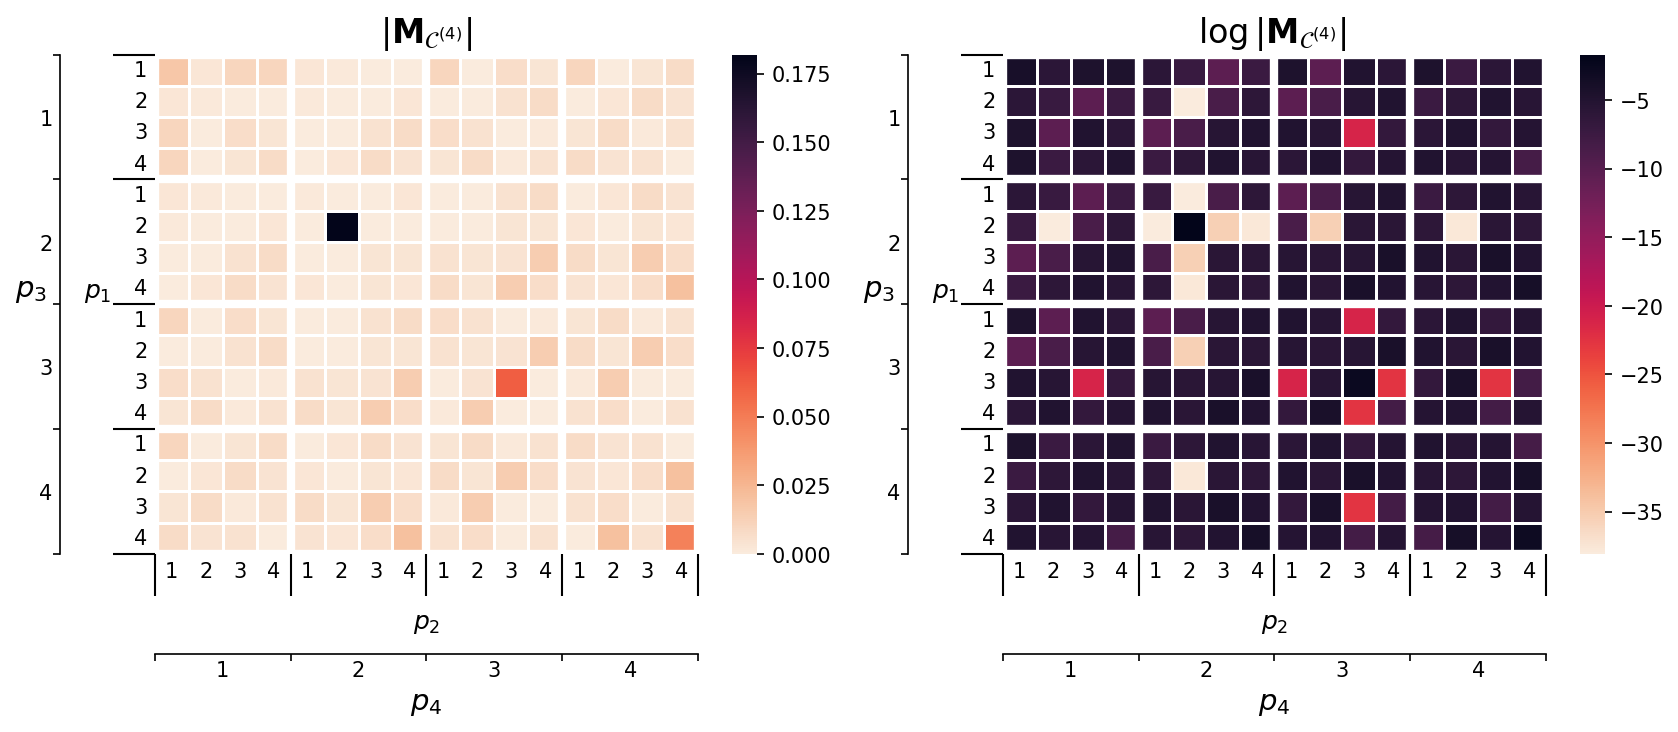

In [13]:
C4t_Shat = mc.cum4tensor(Shat)[0] #*10**(7)
U_Shat = U0
lam_Shat = np.array([C4t_Shat[i,i,i,i] for i in range(Z.shape[0])])

print('CP error:',mc.CPDerror(C4t,lam_Shat,U_Shat,True))
print('Errors:',Shatdict['Errors'])
print('Errortotal:',Shatdict['Error'] ,'mDiag Shat:',mc.measdiag4(C4t_Shat),mc.measdiag4WHITE(C4t,Z,U0))

C4t_Shat = mc.cum4tensor(Z[0:S.shape[0],:])[0]  *10**(7)
C4t_Shat = mc.cum4tensor(S_hatsort[0:S.shape[0],:])[0]  *10**(7)
a1 = np.abs(C4t_Shat.reshape([S.shape[0]**2,S.shape[0]**2]))

C4tS = mc.cum4tensor(S)[0]*10**(7)
print('mDiag S:',mc.measdiag4(C4tS))


a = {}; a[0] = a1; a[1] = np.log(a1)
titles = {}; titles[0] = '$|\mathbf{M}_{\mathcal{C}^{(4)}}|$'; titles[1] = '$\log{|\mathbf{M}_{\mathcal{C}^{(4)}}|}$ '

# Plot cumulant tensor heatmap
fig, ax  = plt.subplots(1,2,figsize=[12,5],dpi=150)
fig.tight_layout(pad=5)

for p in range(len(a)):
    if p == 0:
        sns.heatmap(a[p], linewidth=0.5,ax=ax[p],cmap=sns.cm.rocket_r)
    else:
        sns.heatmap(a[p], linewidth=0.5,ax=ax[p],cmap=sns.cm.rocket_r)

    # Xlabels
    ax[p].set_title(titles[p],fontsize=16)
    ax[p].set_xticks([*np.array([*range(1,S.shape[0]**2+1)])-0.5])
    ax[p].set_xticklabels([*range(1,S.shape[0]+1),*range(1,S.shape[0]+1),*range(1,S.shape[0]+1),*range(1,S.shape[0]+1)])
    ax[p].xaxis.set_minor_locator(ticker.FixedLocator([0,4,8,12,16]))
    ax[p].tick_params(which='minor',length=20,width=1)
    ax[p].tick_params(which='major',length=0,width=0)
    secaxX1 = ax[p].secondary_xaxis(location=-0.2)
    ax[p].set_xlabel('$p_2$',fontsize=12)
    secaxX1.set_xticks([0,4,8,12,16])
    secaxX1.set_xticklabels([])
    secaxX1.xaxis.set_minor_locator(ticker.FixedLocator([2,6,10,14]))
    secaxX1.tick_params(which='minor',length=0)
    secaxX1.set_xlabel('$p_4$',fontsize=14)
    secaxX1.xaxis.set_minor_formatter(ticker.FixedFormatter(['1','2','3','4']))
    ax[p].axes.grid('on',which='minor',linewidth=4,color='w')
    

    # ylabels
    ax[p].set_yticks([*np.array([*range(1,S.shape[0]**2+1)])-0.5])
    ax[p].set_yticklabels([*range(1,S.shape[0]+1),*range(1,S.shape[0]+1),*range(1,S.shape[0]+1),*range(1,S.shape[0]+1)],rotation=0)
    ax[p].yaxis.set_minor_locator(ticker.FixedLocator([0,4,8,12,16]))
    ax[p].tick_params(which='minor',length=20,width=1)
    ax[p].tick_params(which='major',length=0,width=0)
    secaxY1 = ax[p].secondary_yaxis(location=-0.175)
    ax[p].set_ylabel('$p_1$',rotation=0,fontsize=12)
    secaxY1.set_yticks([0,4,8,12,16])
    secaxY1.set_yticklabels([])
    secaxY1.yaxis.set_minor_locator(ticker.FixedLocator([2,6,10,14]))
    secaxY1.tick_params(which='minor',length=0)
    secaxY1.set_ylabel('$p_3$',rotation=0,fontsize=14)
    secaxY1.yaxis.set_minor_formatter(ticker.FixedFormatter(['1','2','3','4']))


The following code window contains the nested loops for the experiment where the BSS problem is repeated n_repeat times for each algorithm for each value of P. 

The values of P that are tested are set with the Prange variable. Prange is now set to start at 4 and end with 10. The n_iter parameter is used to set the maximum amount of iterations each algorithm is allowed to perform and tol is used to set the convergence tolerance.

The 'Sliceselect' parameter can be used to set which slice selection the I-HOSVD and I-GEVD methods use. Set to False if all cumulant tensor slices should be used, set to 'HALF' if only the unique slices should be used and set to True if only the core slices should be used.

In the loops the QRT, FastICA, CPD-gradient (ffIMP) and CPD-fixed-point (ffFICA) methods are tested. First an initialization scheme an be chosen by un-commenting the scheme of choice.
Each function is ran after which its results are verified using the sorting and verification algorithm (function call: mc.Errorfunc(Sources,Estimated sources Shat)) presented in the thesis. The function produces a dictionary containing the permutation and sign correction of the estimated sources such that they match with the true sources, the final errors, the total error, the correlations and the value of whether the estimation was a success or not.

The FastICA (FICA), CPD-gradient (ffIMP) and CPD-fixed-point (ffFICA) methods have a try: and except programming structure. This is for when the method fails the code execution does not halt and the run is just registrered as a fail. The reason why these algorithms fail at times is due to the symmetric orthogonalization step. The 'eigh' function ni the symmetric orthogonalizaion steps fails at times to find a proper eigenvalue decomposition and produces NaN values which cause the functions to fail.

All failed estimates are marked such that removal of these datapoints in the plotting can be done.

In order to evaluate only the diagonality of the subtensor created by only the estimated source components, the line at the bottom of each method which has the comment: # only S subtensor  has to be uncommented.
For example, uncomment the following line in the code window below to compute the diagonality of only the subtensor for the ffFICA method:

#     diag4_ffFICA[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hatffFICA[0:4,:]))         # only S subtensor

In [16]:
# Settings for algorithms
tol = 10**(-4)
n_iter = 300
Prange = [*range(4,11)]
Sliceselect = False         # Option with which can be chosen which selection of cumulant tensor slices should be used by the I-HOSVD and I-GEVD methods.

# Set seed sequence
n_repeat = 100
seed_seq = [*range(n_repeat)]

# Initialize arrays, counters and dictionaries
count_QRT = np.zeros(len(Prange)); count_FICA = np.zeros(len(Prange)); count_ffIMP = np.zeros(len(Prange)); count_ffFICA = np.zeros(len(Prange)); count_HOSVD = np.zeros(len(Prange))
QRT_time = np.zeros([len(Prange),n_repeat]); CPD_errorQRT = np.zeros([len(Prange),n_repeat]); fail_QRT = []; diag4_QRT = np.zeros([len(Prange),n_repeat]); QRT_niter = np.zeros([len(Prange),n_repeat])
FICA_time = np.zeros([len(Prange),n_repeat]); CPD_errorFICA = np.zeros([len(Prange),n_repeat]); fail_FICA = []; diag4_FICA = np.zeros([len(Prange),n_repeat]); FICA_niter = np.zeros([len(Prange),n_repeat])
ffIMP_time = np.zeros([len(Prange),n_repeat]); CPD_errorffIMP = np.zeros([len(Prange),n_repeat]); fail_ffIMP = []; diag4_ffIMP = np.zeros([len(Prange),n_repeat]); ffIMP_niter = np.zeros([len(Prange),2,n_repeat])
ffFICA_time = np.zeros([len(Prange),n_repeat]); CPD_errorffFICA = np.zeros([len(Prange),n_repeat]); fail_ffFICA = []; diag4_ffFICA = np.zeros([len(Prange),n_repeat]); ffFICA_niter = np.zeros([len(Prange),n_repeat])
fail_QRT = 1000*np.ones([len(Prange),n_repeat]); fail_FICA = 1000*np.ones([len(Prange),n_repeat]); fail_ffIMP = 1000*np.ones([len(Prange),n_repeat]); fail_ffFICA = 1000*np.ones([len(Prange),n_repeat])
err_QRT = np.zeros([len(Prange),n_repeat]); err_FICA = np.zeros([len(Prange),n_repeat]); err_ffIMP = np.zeros([len(Prange),n_repeat]); err_ffFICA = np.zeros([len(Prange),n_repeat])
dict_QRT = {}; dict_FICA = {}; dict_ffIMP = {}; dict_ffFICA = {}; dict_HOSVD = {}; 


# Nested loops for performance experiment
for pr,prval in enumerate(Prange):
    print(pr)
    for i in range(n_repeat):
        #  Generate testdata with random mixing matrix
        P = prval
        R = P
        I = 3000
        noise_factor = 0.15
        np.random.seed(seed_seq[i])
        start_end = [0,10]
        X,S,_,_ = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)
        S_backup = np.copy(S)

        # Whiten data SVD
        _,_,Z = mc.SVDinit(X,R,removemean=True)
        Z_backup = np.copy(Z)
        C4t = mc.cum4tensor3(Z)

        # ------------Initialization schemes--------------
        #### no init scheme
        Q0 = np.eye(P); lam0 = np.ones(P)   

        #### Explicit symmetric HOSVD init                                 
        # Q0,_,_ = mtf.my_Tucker1SYM(np.copy(C4t),0)                           # HOSVD init
        # lam0 = np.ones(P)  

        #### Implicit HOSVD init
        # Q0 = mc.HOSVD_iterFINAL(Z,Core_only=Sliceselect)[0]
        # lam0 = np.ones(P)  

        #### Explicit GEVD init
        # Q0,lam0 = mc.CPD_gevd(np.copy(C4t),P)

        ### Implicit GEVD init
        # try:                                                                       # GEVD init
        #     Q0,lam0 = mc.CPD_gevdIMPLICIT_FINAL(np.copy(Z),P,0,SVDCore_only=Sliceselect)
        #     Q0 = Q0[0]
        # except:
        #     Q0,lam0 = mc.CPD_gevdIMPLICIT_FINAL(np.copy(Z),P,0,SVDCore_only=Sliceselect,method=3)
        #     Q0 = Q0[0]

        
        ## ------------Iterative algorithms--------------
        # # ----------QRT method----------
        Z = np.copy(Z_backup)
        start = timer()
        # S_hat_QRT,U0 = mc.QRT4iterIMPLICIT(Z,R,n_repeat,tol)
        S_hat_QRT,U0,err_list,QRT_niter[pr,i] = mc.QRT_FinalFASTWHITE(Z,R,Q0.T,n_iter,tol)
        stop = timer()
        QRT_time[pr,i] = stop-start
        dict_QRT = mc.Errorfunc(np.copy(S),S_hat_QRT)
        count_QRT[pr] += dict_QRT['succes']
        Z = np.copy(Z_backup)
        if dict_QRT['succes']== 0:
            fail_QRT[pr,i] = i
        # Sort in correct order
        S_hatsort = np.copy(S_hat_QRT)
        for p2,pval2 in enumerate(dict_QRT['Finalkeys']):
            S_hat_QRT[p2,:] = np.copy(S_hatsort[pval2,:])

        lam = mc.cum4_diagsWHITE(Z,U0.T)
        CPD_errorQRT[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0.T,True)
        diag4_QRT[pr,i] = mc.measdiag4WHITE(C4t,Z,U0.T) 
        err_QRT[pr,i] = dict_QRT['Error']

        # diag4_QRT[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_QRT[0:4,:]))          # only S subtensor

        # # ----------fastICA----------
        FICA = FastICA(whiten=False,max_iter=n_iter,w_init=Q0.T,tol=tol,fun='cube')
        start = timer()
        try:
            S_hat_FICA,err_listFICA = FICA.fit_transform(Z.T); S_hat_FICA = S_hat_FICA.T
            stop = timer()
            U0 = FICA.mixing_
            FICA_niter[pr,i] = FICA.n_iter_
            FICA_time[pr,i] = stop-start
            dict_FICA = mc.Errorfunc(np.copy(S),S_hat_FICA) 
            count_FICA[pr] += dict_FICA['succes']
            diag4_FICA[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_FICA))
            # err_listFICAstore += err_listFICA 
            if dict_FICA['succes']== 0:
                fail_FICA[pr,i] = i
            # Sort in correct order
            S_hatsort = np.copy(S_hat_FICA)
            for p2,pval2 in enumerate(dict_FICA['Finalkeys']):
                S_hat_FICA[p2,:] = np.copy(S_hatsort[pval2,:])
            Z = np.copy(Z_backup)
            lam = mc.cum4_diagsWHITE(Z,U0)
            CPD_errorFICA[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0,True)
            err_FICA[pr,i] = dict_FICA['Error']

            # diag4_FICA[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_FICA[0:4,:]))        # only S subtensor
        except:
            count_FICA[pr] += 0
            FICA_niter[pr,i] = np.mean(FICA_niter[pr,::i+1])
            fail_FICA[pr,i] = i
            Z = np.copy(Z_backup)
            CPD_errorFICA[pr,i] = np.mean(CPD_errorFICA[pr,::i+1])
            diag4_FICA[pr,i] = np.mean(diag4_FICA[pr,::i+1])
            err_FICA[pr,i] = np.mean( err_FICA[pr,::i+1])


        # #----------ffIMP method----------
        lamU0 = np.r_[lam0,Q0.reshape(P*R,order='F')]
        options={'ftol': tol, 'gtol': tol,'maxfun': n_iter, 'maxiter': n_iter}
        start = timer()
        try:
            solution = sc.optimize.minimize(mc.IMPCPDfunOPT,lamU0,args=(np.copy(Z),0,R),method='L-BFGS-B', jac = True)
            lam = np.copy(solution.x[0:R]); Ufinal = np.copy(solution.x[R::]).reshape([P,R],order='F')
            U0 = mc._sym_decorrelation(Ufinal)
            S_hatffIMP = U0.T @ np.copy(Z)
            stop = timer()
            ffIMP_niter[pr,0,i] = solution.nit
            ffIMP_niter[pr,1,i] = solution.nfev
            ffIMP_time[pr,i] = stop-start
            dict_ffIMP = mc.Errorfunc(np.copy(S),S_hatffIMP)
            count_ffIMP[pr] += dict_ffIMP['succes']
            if dict_ffIMP['succes']== 0:
                fail_ffIMP[pr,i] = i
            # Sort in correct order
            S_hatsort = np.copy(S_hatffIMP)
            for p2,pval2 in enumerate(dict_ffIMP['Finalkeys']):
                S_hatffIMP[p2,:] = np.copy(S_hatsort[pval2,:])
            Z = np.copy(Z_backup)
            CPD_errorffIMP[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0,True)
            diag4_ffIMP[pr,i] = mc.measdiag4WHITE(C4t,Z,U0)
            err_ffIMP[pr,i] = dict_ffIMP['Error']

            # diag4_ffIMP[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hatffIMP[0:4,:]))    # only S subtensor
        except:
            stop = timer()
            ffIMP_time[pr,i] = stop-start
            ffIMP_niter[pr,0,i] = np.mean(ffIMP_niter[pr,0,::i+1].squeeze())
            ffIMP_niter[pr,1,i] = np.mean(ffIMP_niter[pr,1,::i+1].squeeze())
            count_ffIMP[pr] += 0
            fail_ffIMP[pr,i] = i
            CPD_errorffIMP[pr,i] = 1000
            diag4_ffIMP[pr,i] = 1000
            err_ffIMP[pr,i] = 1000

        # ----------ffFICA method----------
        Z = np.copy(Z_backup)
        start = timer()
        try:
            lam,U0,ffFICA_niter[pr,i],_ = mc.symIMPCPDffWHITEFAST(np.copy(Z),np.copy(lam0),np.copy(Q0),P,n_iter,tol)
            S_hatffFICA = U0.T @ np.copy(Z)
        
            stop = timer()
            ffFICA_time[pr,i] = stop-start
            dict_ffFICA = mc.Errorfunc(np.copy(S),S_hatffFICA)
            count_ffFICA[pr] += dict_ffFICA['succes']
            if dict_ffFICA['succes']== 0:
                fail_ffFICA[pr,i] = i
            # Sort in correct order
            S_hatsort = np.copy(S_hatffFICA)
            for p2,pval2 in enumerate(dict_ffFICA['Finalkeys']):
                S_hatffFICA[p2,:] = np.copy(S_hatsort[pval2,:])
            Z = np.copy(Z_backup)
            lam = mc.cum4_diagsWHITE(Z,U0)
            CPD_errorffFICA[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0,True)
            diag4_ffFICA[pr,i] = mc.measdiag4WHITE(C4t,Z,U0)
            err_ffFICA[pr,i] = dict_ffFICA['Error']

            # diag4_ffFICA[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hatffFICA[0:4,:]))         # only S subtensor

        except:
            stop = timer()
            ffFICA_niter[pr,i] = np.mean(ffFICA_niter[pr,::i+1])
            ffFICA_time[pr,i] = stop-start
            count_ffFICA[pr] += 0
            fail_ffFICA[pr,i] = i
            CPD_errorffFICA[pr,i] = 1000
            diag4_ffFICA[pr,i] = 1000
            err_ffFICA[pr,i] = 1000


0
1


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


2


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


3


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


4


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


5


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


6


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])
g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:653: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


In the following code windows all of the results are stored in dictionaries which are then saved into a .mat file. The reason for this being that I compared the results of the algorithms for varying initialization schemes. Instead of looping through all of the schemes which caused my laptop to crash I run the code above for each initialization scheme separately which I then store into a separate .mat file. The.mat files are imported and used in the plot_finalcomps.ipynb file.

In order to store the data into the relevant .mat file un-comment the line corresponding to the scheme.
For example, when tested with the the I-GEVD type-C initialzation scheme un-comment the following statement to save the results in the correct file:

savemat('IGEVDinitCORE_correct_dict.mat',init_dict)

In [17]:
# Store results  
error_Dict = {}
error_Dict['FICA'] = err_FICA; error_Dict['QRT'] = err_QRT; error_Dict['ffIMP'] = err_ffIMP; error_Dict['ffFICA'] = err_ffFICA
diag4_Dict = {}
diag4_Dict['FICA'] = diag4_FICA; diag4_Dict['QRT'] = diag4_QRT; diag4_Dict['ffIMP'] = diag4_ffIMP; diag4_Dict['ffFICA'] = diag4_ffFICA
CPD_error_Dict = {}
CPD_error_Dict['FICA'] = CPD_errorFICA; CPD_error_Dict['QRT'] = CPD_errorQRT; CPD_error_Dict['ffIMP'] = CPD_errorffIMP; CPD_error_Dict['ffFICA'] = CPD_errorffFICA
time_Dict = {}
time_Dict['FICA'] = FICA_time; time_Dict['QRT'] = QRT_time; time_Dict['ffIMP'] = ffIMP_time; time_Dict['ffFICA'] = ffFICA_time
niter_Dict = {}
niter_Dict['FICA'] = FICA_niter; niter_Dict['QRT'] = QRT_niter; niter_Dict['ffIMP'] = ffIMP_niter; niter_Dict['ffFICA'] = ffFICA_niter
fail_Dict = {}
fail_Dict['FICA'] = fail_FICA; fail_Dict['QRT'] = fail_QRT; fail_Dict['ffIMP'] = fail_ffIMP; fail_Dict['ffFICA'] = fail_ffFICA

init_dict = {}; init_dict['error'] = error_Dict; init_dict['diag4'] = diag4_Dict; init_dict['CPD_error'] = CPD_error_Dict; init_dict['time'] = time_Dict
init_dict['niter'] = niter_Dict; init_dict['fail'] = fail_Dict



from scipy.io import savemat
## -------------Save the results of the experiment with the relevant initialization scheme--------
##----- Methods with the full explicit and implicit schemes
# savemat('EYEinit_correct_dict.mat',init_dict)
# savemat('HOSVDinit_correct_dict.mat',init_dict)
# savemat('GEVDinit_correct_dict.mat',init_dict)
# savemat('IGEVDinit_correct_dict.mat',init_dict)

##--------- The U- (HALF) and C- (CORE) type of the I-HOSVD  initialization scheme
# savemat('HOSVDinitHALF_correct_dict.mat',init_dict)
# savemat('HOSVDinitCORE_correct_dict.mat',init_dict)

##--------- The U- (HALF) and C- (CORE) type of the I-GEVD  initialization scheme
# savemat('IGEVDinitHALF_correct_dict.mat',init_dict)
# savemat('IGEVDinitCORE_correct_dict.mat',init_dict)

##--------- The results with subtensor diagonality for No init scheme, explicit HOSVD and explicit GEVD initialization scheme
# savemat('EYEinitDIAG_correct_dict.mat',init_dict)
# savemat('HOSVDinitDIAG_correct_dict.mat',init_dict)
# savemat('GEVDinitDIAG_correct_dict.mat',init_dict)




The code windows below can be used to plot some of the results of the single used initialization scheme.

!! NOTE !!

These are not the final figures used in the thesis. The figures that are presented in the thesis are plotted in the plot_finalcomps.ipynb file.

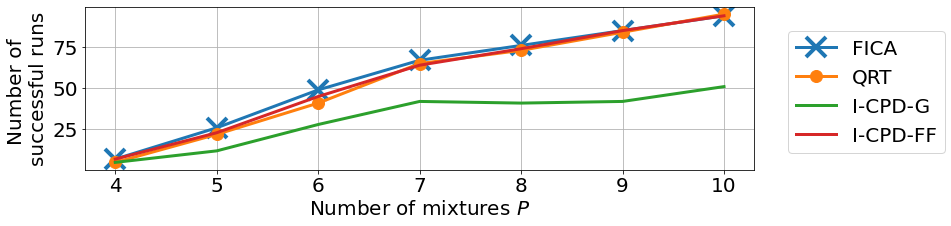

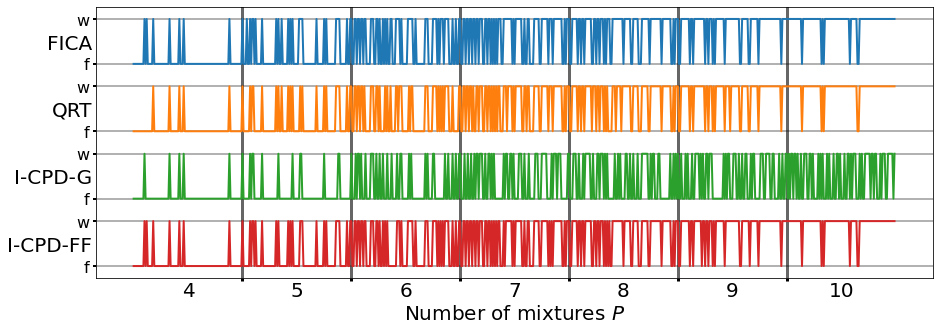

In [18]:
# Plot the failed instances
faillist_FICA = np.ones([len(Prange),n_repeat])
faillist_QRT = np.ones([len(Prange),n_repeat])
faillist_ffIMP = np.ones([len(Prange),n_repeat])
faillist_ffFICA = np.ones([len(Prange),n_repeat])

for p in range(len(Prange)):
    faillist_FICA[p,:][np.copy(fail_FICA[p,:])<100] = 0
    faillist_QRT[p,:][np.copy(fail_QRT[p,:])<100] = 0
    faillist_ffIMP[p,:][np.copy(fail_ffIMP[p,:])<100] = 0
    faillist_ffFICA[p,:][np.copy(fail_ffFICA[p,:])<100] = 0
    

fig,ax = plt.subplots(1,1,figsize=[12,3])
ax.plot(Prange,count_FICA,label='FICA',marker='x',markersize=20,markeredgewidth=4,linewidth=3)
ax.plot(Prange,count_QRT,label='QRT',linewidth=3,marker='o',markersize=12)
ax.plot(Prange,count_ffIMP,label='I-CPD-G',linewidth=3)
ax.plot(Prange,count_ffFICA,label='I-CPD-FF',linewidth=3)
ax.set_xlabel('Number of mixtures $P$',fontsize=20)
ax.set_ylabel('Number of \nsuccessful runs',fontsize=20)
ax.grid('on')
ax.legend(loc=[1.05,0.1],fontsize=20)
ax.tick_params(which='major',axis='x',labelsize=20)
ax.tick_params(which='major',axis='y',labelsize=20)


fig,ax = plt.subplots(1,1,figsize=[15,5])
ax.plot(range(len(Prange)*n_repeat),faillist_FICA.reshape([len(Prange)*n_repeat],order='C'),label='FICA',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),(faillist_QRT-1.5).reshape([len(Prange)*n_repeat],order='C'),label='QRT',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),(faillist_ffIMP-3).reshape([len(Prange)*n_repeat],order='C'),label='I-CPD-G',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),(faillist_ffFICA-4.5).reshape([len(Prange)*n_repeat],order='C'),label='I-CPD-FF',linewidth=2)
ax.set_yticks([0.5,-1,-2.5,-4])
ax.set_yticklabels(labels=['FICA','QRT','I-CPD-G','I-CPD-FF'],fontsize=20)
ax.yaxis.set_minor_locator(ticker.FixedLocator([1,0,-0.5,-1.5,-2,-3,-3.5,-4.5]))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['w','f','w','f','w','f','w','f']))
ax.tick_params(which='major',axis='y',length=0,width=0)
ax.tick_params(which='minor',length=3,width=2,labelsize=16)
ax.set_ylabel('',rotation=0,fontsize=20)
ax.grid('on',which='minor',axis='y',linewidth=2,color='k',alpha=0.3)
ax.set_xticks([n_repeat,2*n_repeat,3*n_repeat,4*n_repeat,5*n_repeat,6*n_repeat])
ax.set_xticklabels(labels=[],fontsize=16)
ax.tick_params(which='major',axis='x',length=3,width=3)
ax.tick_params(which='minor',axis='x',length=0,width=0,labelsize=20)
ax.xaxis.set_minor_locator(ticker.FixedLocator([n_repeat/2,n_repeat/2+n_repeat,n_repeat/2+2*n_repeat,n_repeat/2+3*n_repeat,n_repeat/2+4*n_repeat,n_repeat/2+5*n_repeat,n_repeat/2+6*n_repeat]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(Prange))
ax.set_xlabel('Number of mixtures $P$',fontsize=20)
ax.grid('on',which='major',axis='x',linewidth=3,color='k',alpha=0.6)


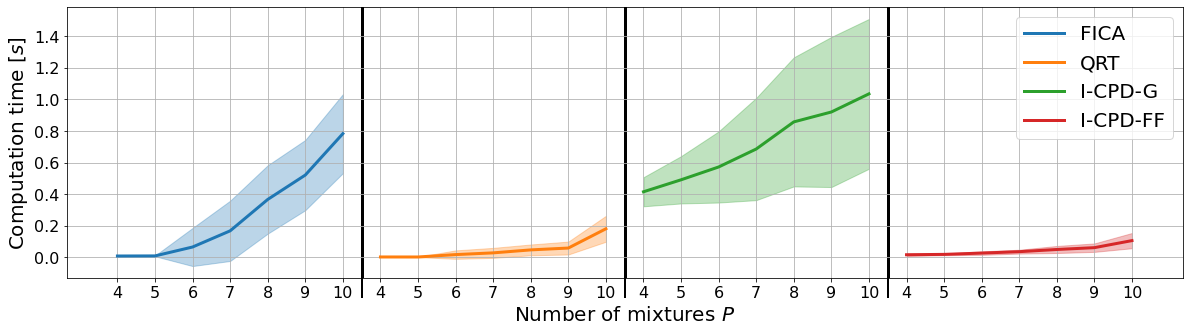

In [19]:
# Time plot over all values for P
ffIMP_time_s = 1*np.copy(ffIMP_time)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

FICA_time_succes = np.mean(FICA_time,axis=1)
QRT_time_succes = np.mean(QRT_time,axis=1)
ffIMP_time_succes = np.mean(ffIMP_time,axis=1)
ffFICA_time_succes = np.mean(ffFICA_time,axis=1)

FICA_time_succes_std = np.std(FICA_time,axis=1)
QRT_time_succes_std = np.std(QRT_time,axis=1)
ffIMP_time_succes_std = np.std(ffIMP_time,axis=1)
ffFICA_time_succes_std = np.std(ffFICA_time,axis=1)

for p in range(len(Prange)):
    FICA_time_succes[p] = np.mean(np.copy(FICA_time)[p,:][np.copy(fail_FICA)[p,:]==1000])
    QRT_time_succes[p] = np.mean(np.copy(QRT_time)[p,:][np.copy(fail_QRT)[p,:]==1000])
    ffIMP_time_succes[p] = np.mean(np.copy(ffIMP_time)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    ffFICA_time_succes[p] = np.mean(np.copy(ffFICA_time)[p,:][np.copy(fail_ffFICA)[p,:]==1000])

    FICA_time_succes_std[p] = np.std(np.copy(FICA_time)[p,:][np.copy(fail_FICA)[p,:]==1000])
    QRT_time_succes_std[p] = np.std(np.copy(QRT_time)[p,:][np.copy(fail_QRT)[p,:]==1000])
    ffIMP_time_succes_std[p] = np.std(np.copy(ffIMP_time)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    ffFICA_time_succes_std[p] = np.std(np.copy(ffFICA_time)[p,:][np.copy(fail_ffFICA)[p,:]==1000])


fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),FICA_time_succes,label='FICA',linewidth=3,color=colors[0])
plt.fill_between(range(len(Prange)),FICA_time_succes-FICA_time_succes_std,FICA_time_succes+FICA_time_succes_std,alpha=.3,color=colors[0])
plt.plot(range(len(Prange),len(Prange)+len(Prange)),QRT_time_succes,label='QRT',linewidth=3,color=colors[1])
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),QRT_time_succes- QRT_time_succes_std,QRT_time_succes+ QRT_time_succes_std,alpha=.3,color=colors[1])
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffIMP_time_succes,label='I-CPD-G',linewidth=3,color=colors[2])
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),ffIMP_time_succes-ffIMP_time_succes_std,ffIMP_time_succes+ffIMP_time_succes_std,alpha=.3,color=colors[2])
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_time_succes,label='I-CPD-FF',linewidth=3,color=colors[3])
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),ffFICA_time_succes-ffFICA_time_succes_std,ffFICA_time_succes+ffFICA_time_succes_std,alpha=.3,color=colors[3])
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))

ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Computation time $[s]$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20)

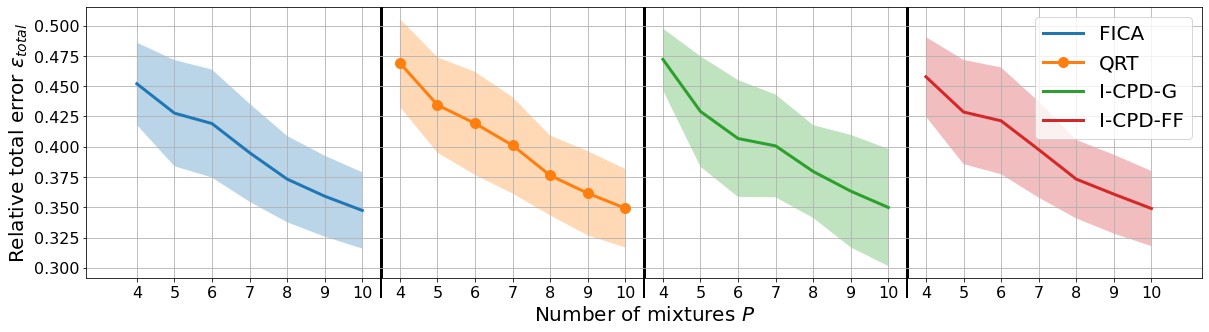

In [20]:
# Plot the errors of successful esitmations
err_FICA_copy = np.mean(err_FICA,axis=1)
err_QRT_copy = np.mean(err_QRT,axis=1)
err_ffIMP_copy = np.mean(err_ffIMP,axis=1)
err_ffFICA_copy = np.mean(err_FICA,axis=1)

err_FICA_copy_std = np.std(err_FICA,axis=1)
err_QRT_copy_std = np.std(err_QRT,axis=1)
err_ffIMP_copy_std = np.std(err_ffIMP,axis=1)
err_ffFICA_copy_std = np.std(err_ffFICA,axis=1)

for p in range(len(Prange)):
    err_FICA_copy[p] = np.mean(np.copy(err_FICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    err_QRT_copy[p] = np.mean(np.copy(err_QRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    err_ffIMP_copy[p] = np.mean(np.copy(err_ffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    err_ffFICA_copy[p] = np.mean(np.copy(err_ffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])

    err_FICA_copy_std[p] = np.std(np.copy(err_FICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    err_QRT_copy_std[p] = np.std(np.copy(err_QRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    err_ffIMP_copy_std[p] = np.std(np.copy(err_ffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    err_ffFICA_copy_std[p] = np.std(np.copy(err_ffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])


# Error plot over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),err_FICA_copy,label='FICA',linewidth=3)
plt.fill_between(range(len(Prange)),err_FICA_copy-err_FICA_copy_std,err_FICA_copy+err_FICA_copy_std,alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),err_QRT_copy,label='QRT',linewidth=3,marker='o',markersize=10)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),err_QRT_copy-err_QRT_copy_std,err_QRT_copy+err_QRT_copy_std,alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_ffIMP_copy,label='I-CPD-G',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),err_ffIMP_copy-err_ffIMP_copy_std,err_ffIMP_copy+err_ffIMP_copy_std,alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_ffFICA_copy,label='I-CPD-FF',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),err_ffFICA_copy-err_ffFICA_copy_std,err_ffFICA_copy+err_ffFICA_copy_std,alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Relative total error $\\varepsilon_{total}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20)

0.856401644026914


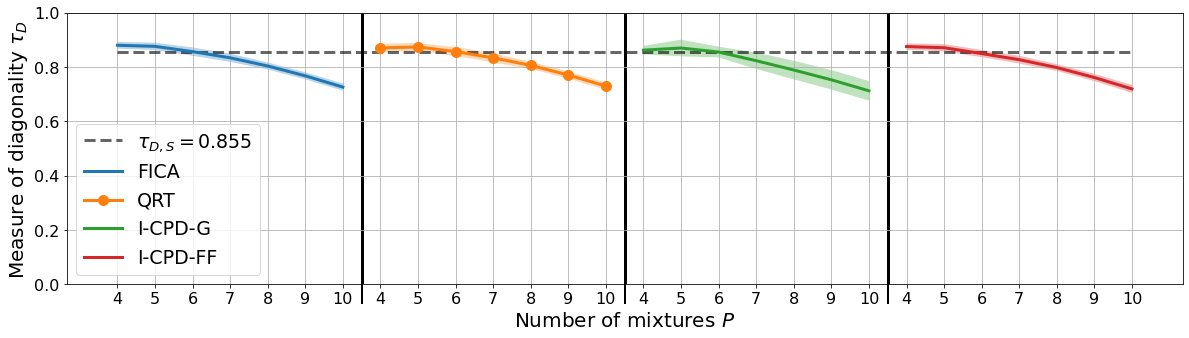

In [21]:
# Plot the diagonality of the transformed cumulant tensor
diag4_FICA_copy = np.mean(diag4_FICA,axis=1)
diag4_QRT_copy = np.mean(diag4_QRT,axis=1)
diag4_ffIMP_copy = np.mean(diag4_ffIMP,axis=1)
diag4_ffFICA_copy = np.mean(diag4_FICA,axis=1)

diag4_FICA_copy_std = np.std(diag4_FICA,axis=1)
diag4_QRT_copy_std = np.std(diag4_QRT,axis=1)
diag4_ffIMP_copy_std = np.std(diag4_ffIMP,axis=1)
diag4_ffFICA_copy_std = np.std(diag4_ffFICA,axis=1)

for p in range(len(Prange)):
    diag4_FICA_copy[p] = np.mean(np.copy(diag4_FICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    diag4_QRT_copy[p] = np.mean(np.copy(diag4_QRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    diag4_ffIMP_copy[p] = np.mean(np.copy(diag4_ffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    diag4_ffFICA_copy[p] = np.mean(np.copy(diag4_ffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])

    diag4_FICA_copy_std[p] = np.std(np.copy(diag4_FICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    diag4_QRT_copy_std[p] = np.std(np.copy(diag4_QRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    diag4_ffIMP_copy_std[p] = np.std(np.copy(diag4_ffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    diag4_ffFICA_copy_std[p] = np.std(np.copy(diag4_ffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])


# Measure of digonality of S
Szmeanunit = np.copy(S)

for p in range(S.shape[0]):
    Szmeanunit[p,:] = Szmeanunit[p,:] - np.mean(Szmeanunit[p,:])
    Szmeanunit[p,:] = Szmeanunit[p,:]/np.sqrt(mtf.my_inner_prod(Szmeanunit[p,:],Szmeanunit[p,:]))
C4tS = mc.cum4tensor(Szmeanunit)[0]
DIAG4S = mc.measdiag4(C4tS)
print(DIAG4S)

# Diag4 plot over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.plot(range(0,len(Prange)*3+len(Prange)),DIAG4S*np.ones(4*len(Prange)),color='k',linestyle='dashed',linewidth=3,alpha=0.6,label='$\\tau_{D,S}=0.855$')


plt.yticks(fontsize=16)
plt.ylim([0,1])
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),diag4_FICA_copy,label='FICA',linewidth=3)
plt.fill_between(range(len(Prange)),diag4_FICA_copy-diag4_FICA_copy_std,diag4_FICA_copy+diag4_FICA_copy_std,alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),diag4_QRT_copy,label='QRT',linewidth=3,marker='o',markersize=10)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),diag4_QRT_copy-diag4_QRT_copy_std,diag4_QRT_copy+diag4_QRT_copy_std,alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),diag4_ffIMP_copy,label='I-CPD-G',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),diag4_ffIMP_copy-diag4_ffIMP_copy_std,diag4_ffIMP_copy+diag4_ffIMP_copy_std,alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),diag4_ffFICA_copy,label='I-CPD-FF',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),diag4_ffFICA_copy-diag4_ffFICA_copy_std,diag4_ffFICA_copy+diag4_ffFICA_copy_std,alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Measure of diagonality $\\tau_{D}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=19)

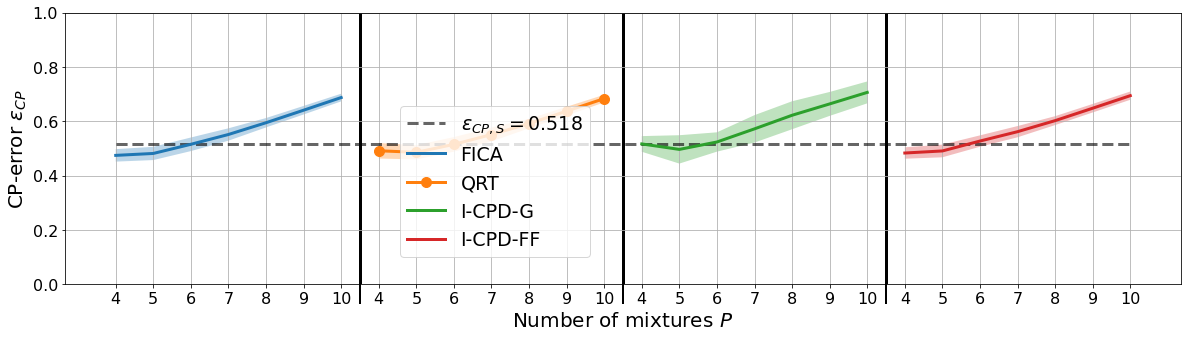

In [22]:
CPD_errorFICA_copy = np.mean(CPD_errorFICA,axis=1)
CPD_errorQRT_copy = np.mean(CPD_errorQRT,axis=1)
CPD_errorffIMP_copy = np.mean(CPD_errorffIMP,axis=1)
CPD_errorffFICA_copy = np.mean(CPD_errorFICA,axis=1)

CPD_errorFICA_copy_std = np.std(CPD_errorFICA,axis=1)
CPD_errorQRT_copy_std = np.std(CPD_errorQRT,axis=1)
CPD_errorffIMP_copy_std = np.std(CPD_errorffIMP,axis=1)
CPD_errorffFICA_copy_std = np.std(CPD_errorffFICA,axis=1)

for p in range(len(Prange)):
    CPD_errorFICA_copy[p] = np.mean(np.copy(CPD_errorFICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    CPD_errorQRT_copy[p] = np.mean(np.copy(CPD_errorQRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    CPD_errorffIMP_copy[p] = np.mean(np.copy(CPD_errorffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    CPD_errorffFICA_copy[p] = np.mean(np.copy(CPD_errorffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])

    CPD_errorFICA_copy_std[p] = np.std(np.copy(CPD_errorFICA)[p,:][np.copy(fail_FICA)[p,:]==1000])
    CPD_errorQRT_copy_std[p] = np.std(np.copy(CPD_errorQRT)[p,:][np.copy(fail_QRT)[p,:]==1000])
    CPD_errorffIMP_copy_std[p] = np.std(np.copy(CPD_errorffIMP)[p,:][np.copy(fail_ffIMP)[p,:]==1000])
    CPD_errorffFICA_copy_std[p] = np.std(np.copy(CPD_errorffFICA)[p,:][np.copy(fail_ffFICA)[p,:]==1000])

# CP error of S with itself
lamS = [C4tS[i,i,i,i] for i in range(S.shape[0])]; US = np.eye(S.shape[0])
CPD_errorS = mc.CPDerror(np.copy(C4tS),lamS,US,True)


# CPD error plot over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
plt.plot(range(0,len(Prange)*3+len(Prange)),CPD_errorS*np.ones(4*len(Prange)),color='k',linestyle='dashed',linewidth=3,alpha=0.6,label='$\\varepsilon_{CP,S}=0.518$')
plt.ylim([0,1])
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),CPD_errorFICA_copy,label='FICA',linewidth=3)
plt.fill_between(range(len(Prange)),CPD_errorFICA_copy-CPD_errorFICA_copy_std,CPD_errorFICA_copy+CPD_errorFICA_copy_std,alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),CPD_errorQRT_copy,label='QRT',linewidth=3,marker='o',markersize=10)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),CPD_errorQRT_copy-CPD_errorQRT_copy_std,CPD_errorQRT_copy+CPD_errorQRT_copy_std,alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),CPD_errorffIMP_copy,label='I-CPD-G',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),CPD_errorffIMP_copy-CPD_errorffIMP_copy_std,CPD_errorffIMP_copy+CPD_errorffIMP_copy_std,alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),CPD_errorffFICA_copy,label='I-CPD-FF',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),CPD_errorffFICA_copy-CPD_errorffFICA_copy_std,CPD_errorffFICA_copy+CPD_errorffFICA_copy_std,alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('CP-error $\\varepsilon_{CP}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=19,loc=[0.3,0.1])

## Non-iterative algorithms

In this section the experiment is run but for the non-iterative algorithms only. The same type of structure in the nested for loops is presen as with the iterative algorithms.

In [24]:
Prange = [*range(4,11)]
Sliceselect = False

# Sets eed sequence
n_repeat = 10
seed_seq = [*range(n_repeat)]

# Initialize variable, arrays and dictionaries
count_HOSVD = np.zeros(len(Prange)); count_IHOSVD = np.zeros(len(Prange)); count_GEVD = np.zeros(len(Prange)); count_IGEVD= np.zeros(len(Prange)); count_IGEVD_ORTHO = np.zeros(len(Prange))
C4t_time = np.zeros([len(Prange),n_repeat])
HOSVD_time = np.zeros([len(Prange),n_repeat]); CPD_errorHOSVD = np.zeros([len(Prange),n_repeat]); fail_HOSVD = 1000*np.ones([len(Prange),n_repeat]); diag4_HOSVD = np.zeros([len(Prange),n_repeat])
IHOSVD_time = np.zeros([len(Prange),n_repeat]); CPD_errorIHOSVD = np.zeros([len(Prange),n_repeat]); fail_IHOSVD = 1000*np.ones([len(Prange),n_repeat]); diag4_IHOSVD = np.zeros([len(Prange),n_repeat])
GEVD_time = np.zeros([len(Prange),n_repeat]); CPD_errorGEVD = np.zeros([len(Prange),2,n_repeat]); fail_GEVD = 1000*np.ones([len(Prange),n_repeat]); diag4_GEVD = np.zeros([len(Prange),n_repeat])
IGEVD_time = np.zeros([len(Prange),n_repeat]); CPD_errorIGEVD = np.zeros([len(Prange),2,n_repeat]); fail_IGEVD = 1000*np.ones([len(Prange),n_repeat]); diag4_IGEVD = np.zeros([len(Prange),n_repeat])
IGEVD_ORTHO_time = np.zeros([len(Prange),n_repeat]); CPD_errorIGEVD_ORTHO = np.zeros([len(Prange),2,n_repeat]); fail_IGEVD_ORTHO = 1000*np.ones([len(Prange),n_repeat]); diag4_IGEVD_ORTHO = np.zeros([len(Prange),n_repeat])
err_HOSVD = np.zeros([len(Prange),n_repeat]); err_IHOSVD = np.zeros([len(Prange),n_repeat]); err_GEVD = np.zeros([len(Prange),n_repeat]); err_IGEVD = np.zeros([len(Prange),n_repeat]); err_IGEVD_ORTHO = np.zeros([len(Prange),n_repeat])
dict_HOSVD = {}; dict_IHOSVD = {}; dict_GEVD = {}; dict_IGEVD = {}; dict_IGEVD_ORTHO = {}



# Nested loops for experiment
for pr,prval in enumerate(Prange):
    print(pr)
    for i in range(n_repeat):
        #  Generate testdata with random mixing matrix
        P = prval
        R = P
        I = 10000
        noise_factor = 0.15 
        np.random.seed(seed_seq[i])
        start_end = [0,10]
        X,S,_,_ = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)
        S_backup = np.copy(S)

        # Whiten data SVD
        _,_,Z = mc.SVDinit(X,R,removemean=True)
        Z_backup = np.copy(Z)
        start = timer()
        C4t = mc.cum4tensor4(Z)
        stop = timer()
        C4t_time[pr,i] = stop-start

        # HOSVD
        start = timer()
        U0 = mtf.my_Tucker1SYM(np.copy(C4t),0)[0]
        S_hat_HOSVD = U0.T @ Z
        stop = timer()
        HOSVD_time[pr,i] = stop-start
        dict_HOSVD = mc.Errorfunc(np.copy(S),S_hat_HOSVD)
        count_HOSVD[pr] += dict_HOSVD['succes']
        Z = np.copy(Z_backup)
        if dict_HOSVD['succes']== 0:
            fail_HOSVD[pr,i] = i
        # Sort in correct order
        S_hatsort = np.copy(S_hat_HOSVD)
        for p2,pval2 in enumerate(dict_HOSVD['Finalkeys']):
            S_hat_HOSVD[p2,:] = np.copy(S_hatsort[pval2,:])
        lam = mc.cum4_diagsWHITE(Z,U0)
        CPD_errorHOSVD[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0,True)
        diag4_HOSVD[pr,i] = mc.measdiag4WHITE(C4t,Z,U0)
        err_HOSVD[pr,i] = dict_HOSVD['Error']

        # diag4_HOSVD[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_HOSVD[0:4,:]))           # for s subtensor only

        # IHOSVD
        start = timer()
        try:
            U0 = mc.HOSVD_iterFINAL(Z,Core_only=Sliceselect)[0]
            S_hat_IHOSVD = U0.T @ Z
            stop = timer()
            IHOSVD_time[pr,i] = stop-start
            dict_IHOSVD = mc.Errorfunc(np.copy(S),S_hat_IHOSVD)
            count_IHOSVD[pr] += dict_IHOSVD['succes']
            if dict_IHOSVD['succes']== 0:
                fail_IHOSVD[pr,i] = i
            # Sort in correct order
            S_hatsort = np.copy(S_hat_IHOSVD)
            for p2,pval2 in enumerate(dict_IHOSVD['Finalkeys']):
                S_hat_IHOSVD[p2,:] = np.copy(S_hatsort[pval2,:])
            Z = np.copy(Z_backup)
            lam = mc.cum4_diagsWHITE(Z,U0)
            CPD_errorIHOSVD[pr,i] = mc.CPDerror(np.copy(C4t),lam,U0,True)
            diag4_IHOSVD[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_IHOSVD))
            err_IHOSVD[pr,i] = dict_IHOSVD['Error']

             # diag4_IHOSVD[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_IHOSVD[0:4,:]))    # for s subtensor only
        except:
            stop = timer()
            IHOSVD_time[pr,i] = stop-start
            count_IHOSVD[pr] += 0
            fail_IHOSVD[pr,i] = i
            Z = np.copy(Z_backup)
            CPD_errorIHOSVD[pr,i] = 1000
            diag4_IHOSVD[pr,i] = 1000
            err_IHOSVD[pr,i] = 1000
    
        # CPD-GEVD
        start = timer()
        U0,lam = mc.CPD_gevd(np.copy(C4t),P)
        S_hat_GEVD = U0[0].T @ Z
        stop = timer()
        GEVD_time[pr,i] = stop-start
        dict_GEVD = mc.Errorfunc(np.copy(S),S_hat_GEVD)
        count_GEVD[pr] += dict_GEVD['succes']
        Z = np.copy(Z_backup)
        if dict_GEVD['succes']== 0:
            fail_GEVD[pr,i] = i
        # Sort in correct order
        S_hatsort = np.copy(S_hat_GEVD)
        for p2,pval2 in enumerate(dict_GEVD['Finalkeys']):
            S_hat_GEVD[p2,:] = np.copy(S_hatsort[pval2,:])
        C4t_Shat = mc.cum4tensor3(U0[0].T @ np.copy(Z))
        CPD_errorGEVD[pr,0,i] = mc.CPDerror(np.copy(C4t),lam,U0[0],True)
        CPD_errorGEVD[pr,1,i] = mc.CPDerror(np.copy(C4t),lam,U0,False)
        diag4_GEVD[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_GEVD[0:4,:]))
        err_GEVD[pr,i] = dict_GEVD['Error']

        # diag4_GEVD[pr,i] = mc.measdiag4(C4t_Shat) #measdiag4WHITE(C4t,Z,U0[0])             # for s subtensor only
    
        # CPD-IGEVD
        start = timer()
        try:
            U0,lam = mc.CPD_gevdIMPLICIT_FINAL(np.copy(Z),P,0,SVDCore_only=Sliceselect)
            S_hat_IGEVD = U0[0].T @ Z
            stop = timer()
            IGEVD_time[pr,i] = stop-start
            dict_IGEVD = mc.Errorfunc(np.copy(S),S_hat_IGEVD)
            count_IGEVD[pr] += dict_IGEVD['succes']
            Z = np.copy(Z_backup)
            if dict_IGEVD['succes']== 0:
                fail_IGEVD[pr,i] = i
            # Sort in correct order
            S_hatsort = np.copy(S_hat_IGEVD)
            for p2,pval2 in enumerate(dict_IGEVD['Finalkeys']):
                S_hat_IGEVD[p2,:] = np.copy(S_hatsort[pval2,:])

            C4t_Shat = mc.cum4tensor3(U0[0].T @ np.copy(Z)) #*10**(7)
            CPD_errorIGEVD[pr,0,i] = mc.CPDerror(np.copy(C4t),lam,U0[0],True)
            CPD_errorIGEVD[pr,1,i] = mc.CPDerror(np.copy(C4t),lam,U0,False)
            diag4_IGEVD[pr,i] = mc.measdiag4(mc.cum4tensor3(S_hat_IGEVD[0:4,:]))
            err_IGEVD[pr,i] = dict_IGEVD['Error']

            # diag4_IGEVD[pr,i] = mc.measdiag4(C4t_Shat) #measdiag4WHITE(C4t,Z,U0[0])               # for s subtensor only
  
        except:
            stop = timer()
            IGEVD_time[pr,i] = stop-start
     
            count_IGEVD[pr] += 0
            fail_IGEVD[pr,i] = i
            CPD_errorIGEVD[pr,0,i] = 1000
            CPD_errorIGEVD[pr,1,i] = 1000
            diag4_IGEVD[pr,i] = 1000
            err_IGEVD[pr,i] = 1000
    

print(count_HOSVD,count_IHOSVD,count_GEVD,count_IGEVD,count_IGEVD_ORTHO)

0
1
2
3
4
5
6
[0. 1. 1. 1. 0. 1. 1.] [0. 1. 1. 1. 0. 1. 1.] [0. 1. 1. 2. 3. 1. 0.] [0. 0. 0. 0. 0. 3. 1.] [0. 0. 0. 0. 0. 0. 0.]


The code below is again used to store the results of the experiment for varying settings into separate .mat files which can then be plotted together into a single plot in the plot_finalcomps.ipynb file.

In [25]:
# Store results  
error_Dict = {}
error_Dict['HOSVD'] = err_HOSVD; error_Dict['IHOSVD'] = err_IHOSVD; error_Dict['GEVD'] = err_GEVD; error_Dict['IGEVD'] = err_IGEVD; error_Dict['IGEVD_ORTHO'] = err_IGEVD_ORTHO
diag4_Dict = {}
diag4_Dict['HOSVD'] = diag4_HOSVD; diag4_Dict['IHOSVD'] = diag4_IHOSVD; diag4_Dict['GEVD'] = diag4_GEVD; diag4_Dict['IGEVD'] = diag4_IGEVD; diag4_Dict['IGEVD_ORTHO'] = diag4_IGEVD_ORTHO
CPD_error_Dict = {}
CPD_error_Dict['HOSVD'] = CPD_errorHOSVD; CPD_error_Dict['IHOSVD'] = CPD_errorIHOSVD; CPD_error_Dict['GEVD'] = CPD_errorGEVD; CPD_error_Dict['IGEVD'] = CPD_errorIGEVD; CPD_error_Dict['IGEVD_ORTHO'] = CPD_errorIGEVD_ORTHO
time_Dict = {}
time_Dict['HOSVD'] = HOSVD_time; time_Dict['IHOSVD'] = IHOSVD_time; time_Dict['GEVD'] = GEVD_time; time_Dict['IGEVD'] = IGEVD_time; time_Dict['IGEVD_ORTHO'] = IGEVD_ORTHO_time
fail_Dict = {}
fail_Dict['HOSVD'] = fail_HOSVD; fail_Dict['IHOSVD'] = fail_IHOSVD; fail_Dict['GEVD'] = fail_GEVD; fail_Dict['IGEVD'] = fail_IGEVD; fail_Dict['IGEVD_ORTHO'] = fail_IGEVD_ORTHO

init_dict = {}; init_dict['error'] = error_Dict; init_dict['diag4'] = diag4_Dict; init_dict['CPD_error'] = CPD_error_Dict; init_dict['time'] = time_Dict
init_dict['fail'] = fail_Dict; init_dict['C4t-time'] = C4t_time

from scipy.io import savemat
# CORRECT
# savemat('NONiter100_correctFULL_dict.mat',init_dict)
# savemat('NONiter100_correctHALF_dict.mat',init_dict)
# savemat('NONiter100_correctCORE_dict.mat',init_dict)

# savemat('NONiter100DIAG_correctFULL_dict.mat',init_dict)
# savemat('NONiter100DIAG_correctHALF_dict.mat',init_dict)
# savemat('NONiter100DIAG_correctCORE_dict.mat',init_dict)



Similar as with the iterative algorithms the code windows below can be used to plot some of the results of the non-iterative methods. However, there is an additional code window in between which measures the computation time taken by the computation of the cumulant tensor. The reason why this is done separately is that it takes quite a while on my laptop.

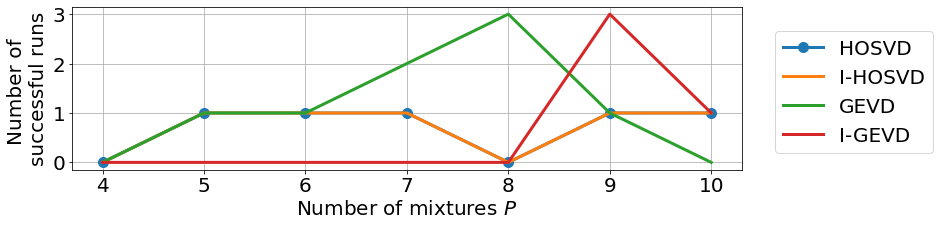

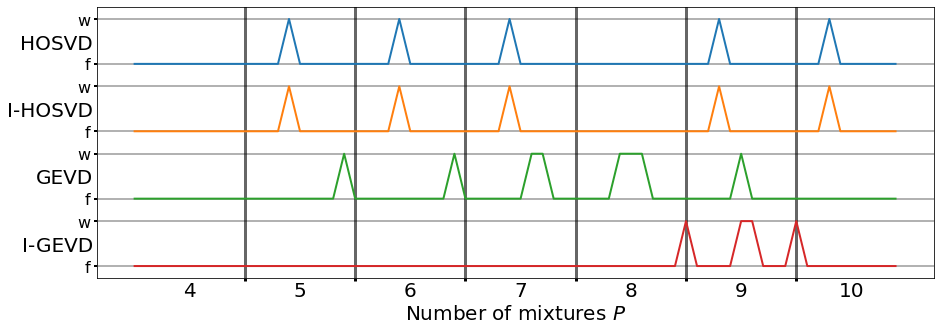

In [27]:
# Plot the failed instances
faillist_HOSVD = np.ones(len(Prange)*n_repeat)
faillist_IHOSVD = np.ones(len(Prange)*n_repeat)
faillist_GEVD = np.ones(len(Prange)*n_repeat)
faillist_IGEVD = np.ones(len(Prange)*n_repeat)

for p in range(len(Prange)):
    faillist_HOSVD[p*n_repeat:(p+1)*n_repeat][np.copy(fail_HOSVD)[p,:] != 1000] = 0
    faillist_IHOSVD[p*n_repeat:(p+1)*n_repeat][np.copy(fail_IHOSVD)[p,:] != 1000] = 0
    faillist_GEVD[p*n_repeat:(p+1)*n_repeat][np.copy(fail_GEVD)[p,:] != 1000] = 0
    faillist_IGEVD[p*n_repeat:(p+1)*n_repeat][np.copy(fail_IGEVD)[p,:] != 1000] = 0
    

fig,ax = plt.subplots(1,1,figsize=[12,3])
ax.plot(Prange,count_HOSVD,label='HOSVD',marker='o',markersize=10,linewidth=3)
ax.plot(Prange,count_IHOSVD,label='I-HOSVD',linewidth=3)
ax.plot(Prange,count_GEVD,label='GEVD',linewidth=3)
ax.plot(Prange,count_IGEVD,label='I-GEVD',linewidth=3)
ax.set_xlabel('Number of mixtures $P$',fontsize=20)
ax.set_ylabel('Number of \nsuccessful runs',fontsize=20)
ax.grid('on')
ax.legend(loc=[1.05,0.1],fontsize=20)
ax.tick_params(which='major',axis='x',labelsize=20)
ax.tick_params(which='major',axis='y',labelsize=20)


fig,ax = plt.subplots(1,1,figsize=[15,5])
ax.plot(range(len(Prange)*n_repeat),faillist_HOSVD,label='HOSVD',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),faillist_IHOSVD-1.5,label='I-HOSVD',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),faillist_GEVD-3,label='GEVD',linewidth=2)
ax.plot(range(len(Prange)*n_repeat),faillist_IGEVD-4.5,label='I-GEVD',linewidth=2)
ax.set_yticks([0.5,-1,-2.5,-4])
ax.set_yticklabels(labels=['HOSVD','I-HOSVD','GEVD','I-GEVD'],fontsize=20)
ax.yaxis.set_minor_locator(ticker.FixedLocator([1,0,-0.5,-1.5,-2,-3,-3.5,-4.5]))
ax.yaxis.set_minor_formatter(ticker.FixedFormatter(['w','f','w','f','w','f','w','f']))
ax.tick_params(which='major',axis='y',length=0,width=0)
ax.tick_params(which='minor',length=3,width=2,labelsize=16)
ax.set_ylabel('',rotation=0,fontsize=20)
ax.grid('on',which='minor',axis='y',linewidth=2,color='k',alpha=0.3)
ax.set_xticks([n_repeat,2*n_repeat,3*n_repeat,4*n_repeat,5*n_repeat,6*n_repeat])
ax.set_xticklabels(labels=[],fontsize=16)
ax.tick_params(which='major',axis='x',length=3,width=3)
ax.tick_params(which='minor',axis='x',length=0,width=0,labelsize=20)
ax.xaxis.set_minor_locator(ticker.FixedLocator([n_repeat/2,n_repeat/2+n_repeat,n_repeat/2+2*n_repeat,n_repeat/2+3*n_repeat,n_repeat/2+4*n_repeat,n_repeat/2+5*n_repeat,n_repeat/2+6*n_repeat]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(Prange))
ax.set_xlabel('Number of mixtures $P$',fontsize=20)
ax.grid('on',which='major',axis='x',linewidth=3,color='k',alpha=0.6)


The code below is to store the time needed to compute the cumulant tensor when it is created in slicewise fashion just as I-HOSVD does.

In [32]:
# For Fair comparison: use the per slice computation
def cum4tensor4(X):
    I = X.shape[1]
    P = X.shape[0]
    C4t = np.zeros([P,P,P,P])
    for p1 in range(P):
        for p2 in range(P):
            MC = 1/I*Z@Z.T
            MT = 1/I*Z @ (Z[p1,:].reshape([1,I])*Z[p2,:].reshape([1,I]) * Z).T - MC*MC[p1,p2] - np.multiply.outer(MC[p1,:],MC[:,p2]) - np.multiply.outer(MC[:,p1],MC[p2,:])
            C4t[:,:,p1,p2] = MT
    return MT

Irange = [10000]
C4t_time_fast3 = np.zeros([len(Irange),len(Prange),n_repeat])

for Ii,Iival in enumerate(Irange):
    for i in range(n_repeat):
        for p,pval in enumerate(Prange):
            P = pval
            R = P
            I = Iival
            noise_factor = 0.15
            start_end = [0,10]
            X,S,_,_ = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)

            # Whiten data SVD
            _,_,Z = mc.SVDinit(X,R,removemean=True)

            start = timer()
            cum4tensor4(Z)[0]
            stop = timer()
            C4t_time_fast3[Ii,p,i] = stop-start

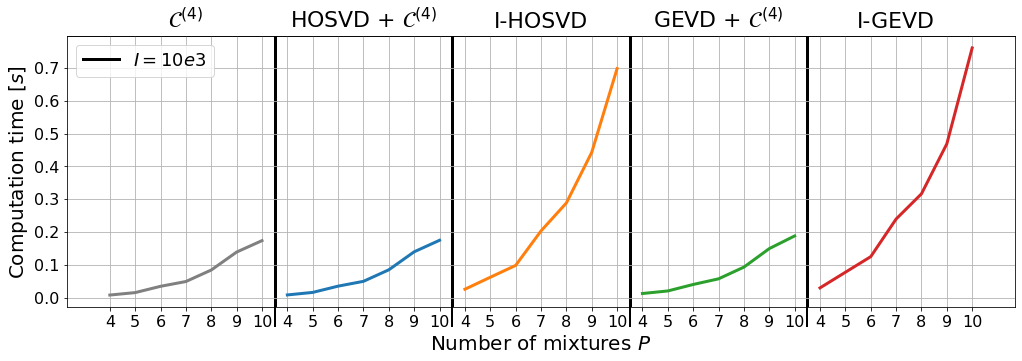

In [36]:
# Plot the resulting time averages
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

C4t_time1 = np.copy(C4t_time_fast3[0,:,:].squeeze())

diff_IHOSVD_IGEVD = np.copy(IGEVD_time) - np.copy(IHOSVD_time)
IHOSVD_time_new1 = np.copy(IHOSVD_time)
IGEVD_time_new1 = IHOSVD_time_new1 + np.abs(diff_IHOSVD_IGEVD)


marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]


# Time plot over all values for P
fig,ax = plt.subplots(figsize=[17,5])
plt.yticks(fontsize=16)
# plt.ylim([0,0.8])
ax.set_xticks([*range(len(Prange)*5)])
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
p1, = plt.plot(range(len(Prange)),np.mean(C4t_time1,axis=1),label='$\mathcal{C}^{(4)}$',linewidth=3,color='gray',linestyle=linestyleL[0],marker=marklist[0],markeredgewidth=4,markersize=sizeL[0])
# plt.fill_between(range(len(Prange)),np.mean(C4t_time+HOSVD_time,axis=1)-np.std(C4t_time+HOSVD_time,axis=1),np.mean(C4t_time+HOSVD_time,axis=1)+np.std(C4t_time+HOSVD_time,axis=1),alpha=.3,color='k')

plt.plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(C4t_time1+HOSVD_time,axis=1),label='HOSVD + $\mathcal{C}^{(4)}$',linewidth=3,color=colors[0],linestyle=linestyleL[0],marker=marklist[0],markeredgewidth=4,markersize=sizeL[0])
# plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(C4t_time+HOSVD_time,axis=1)-np.std(C4t_time+HOSVD_time,axis=1),np.mean(C4t_time+HOSVD_time,axis=1)+np.std(C4t_time+HOSVD_time,axis=1),alpha=.3,color=colors[0])

plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(IHOSVD_time_new1,axis=1),label='I-HOSVD',linewidth=3,color=colors[1],linestyle=linestyleL[0],marker=marklist[0],markeredgewidth=4,markersize=sizeL[0])
# plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(IHOSVD_time_new1,axis=1)-np.std(IHOSVD_time_new1,axis=1),np.mean(IHOSVD_time_new1,axis=1)+np.std(IHOSVD_time_new1,axis=1),alpha=.3,color=colors[1])

plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(C4t_time1+GEVD_time,axis=1),label='GEVD + $\mathcal{C}^{(4)}$',linewidth=3,color=colors[2],linestyle=linestyleL[0],marker=marklist[0],markeredgewidth=4,markersize=sizeL[0])
# plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(C4t_time+GEVD_time,axis=1)-np.std(C4t_time+GEVD_time,axis=1),np.mean(C4t_time+GEVD_time,axis=1)+np.std(C4t_time+GEVD_time[0][0],axis=1),alpha=.3,color=colors[2])

plt.plot(range(len(Prange)*4,len(Prange)+len(Prange)*4),np.mean(IGEVD_time_new1,axis=1),label='I-GEVD',linewidth=3,color=colors[3],linestyle=linestyleL[0],marker=marklist[0],markeredgewidth=4,markersize=sizeL[0])
# plt.fill_between(range(len(Prange)*4,len(Prange)+len(Prange)*4),np.mean(IGEVD_time_new1,axis=1)-np.std(IGEVD_time_new1,axis=1),np.mean(IGEVD_time_new1,axis=1)+np.std(IGEVD_time_new1,axis=1),alpha=.3,color=colors[3])

ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),5*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Computation time $[s]$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
# plt.legend(fontsize=20)

secaxX1 = ax.secondary_xaxis(location=1)
secaxX1.set_xticks([3,10,17,24,31])
secaxX1.set_xticklabels(['$\mathcal{C}^{(4)}$','HOSVD + $\mathcal{C}^{(4)}$','I-HOSVD','GEVD + $\mathcal{C}^{(4)}$','I-GEVD'],fontsize=22)
secaxX1.tick_params(which='major',length=0)

leg = plt.legend(handles=[p1],labels=['$I=10e3$'],fontsize=18,loc='upper left')
title = leg.get_title()
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')

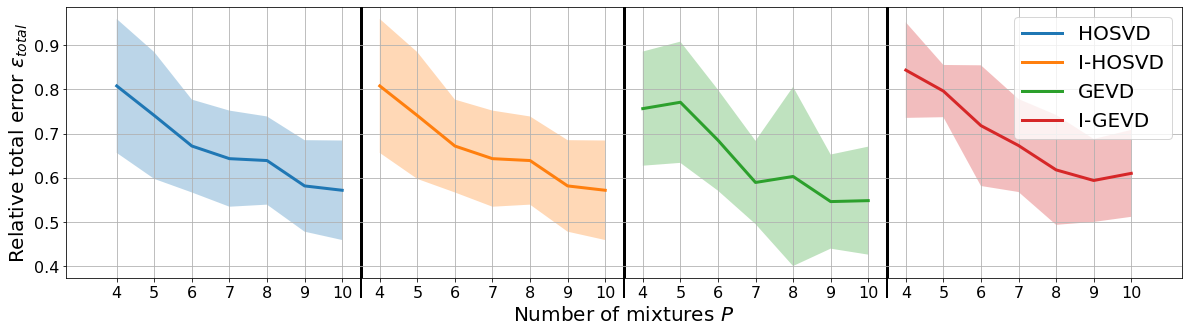

In [37]:
# Remove failed instances
err_IHOSVD_copy = np.copy(err_IHOSVD)
err_IGEVD_copy = np.copy(err_IGEVD)
for p in range(len(Prange)):
    L_err_IHOSVD = list(err_IHOSVD_copy[p,:])
    L_err_IHOSVDNEW = [i for i in L_err_IHOSVD if i < 10]
    err_IHOSVD_copy[p,:][err_IHOSVD_copy[p,:] > 10] = np.mean(L_err_IHOSVDNEW)

    L_err_IGEVD = list(err_IGEVD_copy[p,:])
    L_err_IGEVDNEW = [i for i in L_err_IGEVD if i < 10]
    err_IGEVD_copy[p,:][err_IGEVD_copy[p,:] > 10] = np.mean(L_err_IGEVDNEW)

# Plot errors over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),np.mean(err_HOSVD,axis=1),label='HOSVD',linewidth=3)
plt.fill_between(range(len(Prange)),np.mean(err_HOSVD,axis=1)-np.std(err_HOSVD,axis=1),np.mean(err_HOSVD,axis=1)+np.std(err_HOSVD,axis=1),alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(err_IHOSVD_copy,axis=1),label='I-HOSVD',linewidth=3)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(err_IHOSVD_copy,axis=1)-np.std(err_IHOSVD_copy,axis=1),np.mean(err_IHOSVD_copy,axis=1)+np.std(err_IHOSVD_copy,axis=1),alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(err_GEVD,axis=1),label='GEVD',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(err_GEVD,axis=1)-np.std(err_GEVD,axis=1),np.mean(err_GEVD,axis=1)+np.std(err_GEVD,axis=1),alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(err_IGEVD_copy,axis=1),label='I-GEVD',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(err_IGEVD_copy,axis=1)-np.std(err_IGEVD_copy,axis=1),np.mean(err_IGEVD_copy,axis=1)+np.std(err_IGEVD_copy,axis=1),alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Relative total error $\\varepsilon_{total}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20)

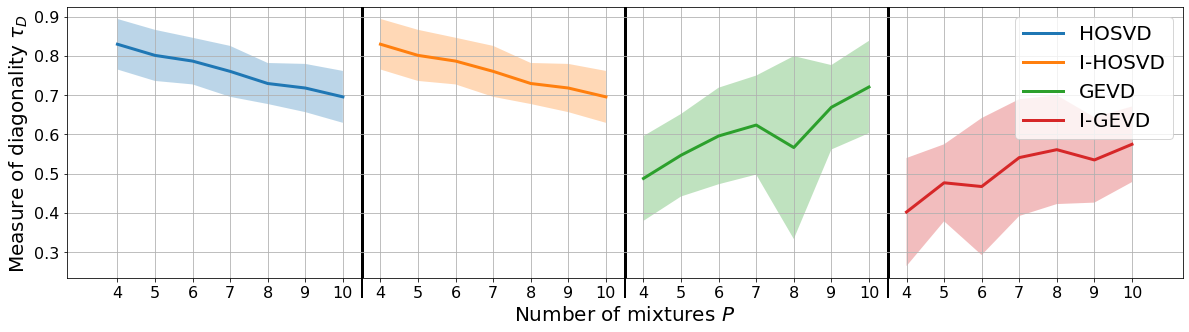

In [38]:
# Remove failed instances
diag4_IHOSVD_copy = np.copy(diag4_IHOSVD)
diag4_IGEVD_copy = np.copy(diag4_IGEVD)
for p in range(len(Prange)):
    L_diag4_IHOSVD = list(diag4_IHOSVD_copy[p,:])
    L_diag4_IHOSVDNEW = [i for i in L_diag4_IHOSVD if i < 999]
    diag4_IHOSVD_copy[p,:][diag4_IHOSVD_copy[p,:] == 1000] = np.mean(L_diag4_IHOSVDNEW)

    L_diag4_IGEVD = list(diag4_IGEVD_copy[p,:])
    L_diag4_IGEVDNEW = [i for i in L_diag4_IGEVD if i < 999]
    diag4_IGEVD_copy[p,:][diag4_IGEVD_copy[p,:] == 1000] = np.mean(L_diag4_IGEVDNEW)

# Diagonality plot over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),np.mean(diag4_HOSVD,axis=1),label='HOSVD',linewidth=3)
plt.fill_between(range(len(Prange)),np.mean(diag4_HOSVD,axis=1)-np.std(diag4_HOSVD,axis=1),np.mean(diag4_HOSVD,axis=1)+np.std(diag4_HOSVD,axis=1),alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD,axis=1),label='I-HOSVD',linewidth=3)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(diag4_IHOSVD,axis=1)-np.std(diag4_IHOSVD,axis=1),np.mean(diag4_IHOSVD,axis=1)+np.std(diag4_IHOSVD,axis=1),alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_GEVD,axis=1),label='GEVD',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(diag4_GEVD,axis=1)-np.std(diag4_GEVD,axis=1),np.mean(diag4_GEVD,axis=1)+np.std(diag4_GEVD,axis=1),alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD_copy,axis=1),label='I-GEVD',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(diag4_IGEVD_copy,axis=1)-np.std(diag4_IGEVD_copy,axis=1),np.mean(diag4_IGEVD_copy,axis=1)+np.std(diag4_IGEVD_copy,axis=1),alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Measure of diagonality $\\tau_{D}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20)

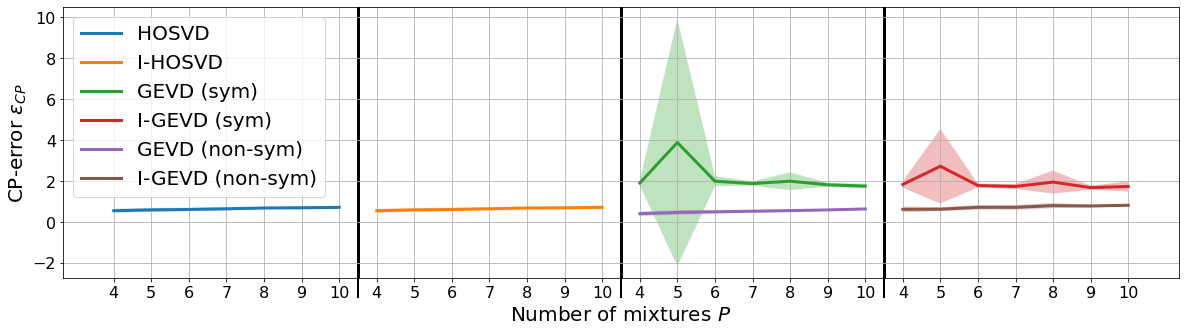

In [39]:
# Remove failed instances
CPD_errorIHOSVD_copy = np.copy(CPD_errorIHOSVD)
CPD_errorGEVD_copy = np.copy(CPD_errorGEVD)
CPD_errorIGEVD_copy = np.copy(CPD_errorIGEVD)
for p in range(len(Prange)):
    L_CPD_errorIHOSVD = list(CPD_errorIHOSVD_copy[p,:])
    L_CPD_errorIHOSVDNEW = [i for i in L_CPD_errorIHOSVD if i < 999]
    CPD_errorIHOSVD_copy[p,:][CPD_errorIHOSVD_copy[p,:] == 1000] = np.mean(L_CPD_errorIHOSVDNEW)

    L_CPD_errorGEVD = list(CPD_errorGEVD_copy[p,0,:])
    L_CPD_errorGEVDNEW = [i for i in L_CPD_errorGEVD if i < 100]
    CPD_errorGEVD_copy[p,0,:][CPD_errorGEVD_copy[p,0,:] > 100] = np.mean(L_CPD_errorGEVDNEW)

    L_CPD_errorGEVD = list(CPD_errorGEVD_copy[p,1,:])
    L_CPD_errorGEVDNEW = [i for i in L_CPD_errorGEVD if i < 100]
    CPD_errorGEVD_copy[p,1,:][CPD_errorGEVD_copy[p,1,:] > 100] = np.mean(L_CPD_errorGEVDNEW)

    L_CPD_errorIGEVD = list(CPD_errorIGEVD_copy[p,0,:])
    L_CPD_errorIGEVDNEW = [i for i in L_CPD_errorIGEVD if i < 100]
    CPD_errorIGEVD_copy[p,0,:][CPD_errorIGEVD_copy[p,0,:] > 100] = np.mean(L_CPD_errorIGEVDNEW)

    L_CPD_errorIGEVD = list(CPD_errorIGEVD_copy[p,1,:])
    L_CPD_errorIGEVDNEW = [i for i in L_CPD_errorIGEVD if i < 100]
    CPD_errorIGEVD_copy[p,1,:][CPD_errorIGEVD_copy[p,1,:] > 100] = np.mean(L_CPD_errorIGEVDNEW)

# CP-error plot over all values for P
fig,ax = plt.subplots(figsize=[20,5])
ax.set_xticks([*range(len(Prange)*4)])
plt.yticks(fontsize=16)
ax.set_xticklabels([*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange)),*range(Prange[0],Prange[0]+len(Prange))],fontsize=16)
plt.plot(range(len(Prange)),np.mean(CPD_errorHOSVD,axis=1),label='HOSVD',linewidth=3)
plt.fill_between(range(len(Prange)),np.mean(CPD_errorHOSVD,axis=1)-np.std(CPD_errorHOSVD,axis=1),np.mean(CPD_errorHOSVD,axis=1)+np.std(CPD_errorHOSVD,axis=1),alpha=.3)
plt.plot(range(len(Prange),len(Prange)+len(Prange)),np.mean(CPD_errorIHOSVD_copy,axis=1),label='I-HOSVD',linewidth=3)
plt.fill_between(range(len(Prange),len(Prange)+len(Prange)),np.mean(CPD_errorIHOSVD_copy,axis=1)-np.std(CPD_errorIHOSVD_copy,axis=1),np.mean(CPD_errorIHOSVD_copy,axis=1)+np.std(CPD_errorIHOSVD_copy,axis=1),alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(CPD_errorGEVD_copy[:,0,:].squeeze(),axis=1),label='GEVD (sym)',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(CPD_errorGEVD_copy[:,0,:].squeeze(),axis=1)-np.std(CPD_errorGEVD_copy[:,0,:].squeeze(),axis=1),np.mean(CPD_errorGEVD_copy[:,0,:].squeeze(),axis=1)+np.std(CPD_errorGEVD_copy[:,0,:].squeeze(),axis=1),alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(CPD_errorIGEVD_copy[:,0,:].squeeze(),axis=1),label='I-GEVD (sym)',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(CPD_errorIGEVD_copy[:,0,:].squeeze(),axis=1)-np.std(CPD_errorIGEVD_copy[:,0,:].squeeze(),axis=1),np.mean(CPD_errorIGEVD_copy[:,0,:].squeeze(),axis=1)+np.std(CPD_errorIGEVD_copy[:,0,:].squeeze(),axis=1),alpha=.3)
plt.plot(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(CPD_errorGEVD_copy[:,1,:].squeeze(),axis=1),label='GEVD (non-sym)',linewidth=3)
plt.fill_between(range(len(Prange)*2,len(Prange)+len(Prange)*2),np.mean(CPD_errorGEVD_copy[:,1,:].squeeze(),axis=1)-np.std(CPD_errorGEVD_copy[:,1,:].squeeze(),axis=1),np.mean(CPD_errorGEVD_copy[:,1,:].squeeze(),axis=1)+np.std(CPD_errorGEVD_copy[:,1,:].squeeze(),axis=1),alpha=.3)
plt.plot(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(CPD_errorIGEVD_copy[:,1,:].squeeze(),axis=1),label='I-GEVD (non-sym)',linewidth=3)
plt.fill_between(range(len(Prange)*3,len(Prange)+len(Prange)*3),np.mean(CPD_errorIGEVD_copy[:,1,:].squeeze(),axis=1)-np.std(CPD_errorIGEVD_copy[:,1,:].squeeze(),axis=1),np.mean(CPD_errorIGEVD_copy[:,1,:].squeeze(),axis=1)+np.std(CPD_errorIGEVD_copy[:,1,:].squeeze(),axis=1),alpha=.3)
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('CP-error $\\varepsilon_{CP}$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20)

## symmetric orthogonalization vs QR

The following code box is used to verify the computational difference between QR decomposition and the symmetric orthogonalization step from the FastICA, CP-gradient and CP-fixed-point algorithms.

In [57]:
Prange = [*range(4,11)]

n_repeat = 50000

time_symorth = np.zeros([len(Prange),n_repeat])
time_qr = np.zeros([len(Prange),n_repeat])

for p,pval in enumerate(Prange):
    for i in range(n_repeat):
        np.random.seed(i)
        P = pval
        M = np.random.rand(P,P); M = M @ M.T

        start = timer()
        mc._sym_decorrelation(M)
        stop = timer()
        time_symorth[p,i] = stop-start

        np.random.seed(i)
        P = pval
        M = np.random.rand(P,P); M = M @ M.T

        start = timer()
        sc.linalg.qr(M)[0]
        stop = timer()
        time_qr[p,i] = stop-start


g:\My Drive\Master Systems and Control\Literature & Thesis\Python Literature & Thesis\myCumulantfunctions.py:581: RuntimeWarning: invalid value encountered in sqrt
  return np.linalg.multi_dot([u * (1.0 / np.sqrt(s)), u.T, W])


[0.00012103 0.00011269 0.00016125 0.00019928 0.00022071 0.00024807
 0.00028812]
[9.06702818e-05 8.39105539e-05 8.44355539e-05 9.40685558e-05
 9.15055624e-05 9.55675964e-05 1.02660060e-04]


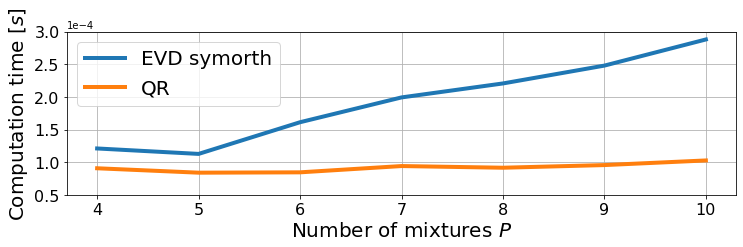

In [58]:
print(np.mean(time_symorth,axis=1))
print(np.mean(time_qr,axis=1))

fig,ax = plt.subplots(figsize=[12,3])
ax.set_xticks([*range(len(Prange))])
plt.yticks(fontsize=16)
plt.ylim([0.00005,0.0003])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xticklabels(Prange,fontsize=16)
plt.plot(np.mean(time_symorth,axis=1),label='EVD symorth',linewidth=4)
plt.fill_between(np.mean(time_symorth,axis=1)-np.std(time_symorth,axis=1),np.mean(time_symorth,axis=1)+np.std(time_symorth,axis=1),alpha=.3)
plt.plot(np.mean(time_qr,axis=1),label='QR',linewidth=4)
plt.fill_between(np.mean(time_qr,axis=1)-np.std(time_qr,axis=1),np.mean(time_qr,axis=1)+np.std(time_qr,axis=1),alpha=.3)
# ax.xaxis.set_minor_locator(ticker.FixedLocator(np.array([*range(len(Prange),4*len(Prange),len(Prange))])-0.5))
# ax.tick_params(which='minor',length=20,width=2)
plt.xlabel('Number of mixtures $P$',fontsize=20)
plt.ylabel('Computation time $[s]$',fontsize=20)
plt.grid('on',which='minor',linewidth=3,color='k')
plt.grid('on',which='major')
plt.legend(fontsize=20,loc='upper left')


# PLot performance of larger sets of QR and FICA

The code below can be used to plot the average computation time needed by the QRT and FastICA algorithms for datasets with larger amounts of mixtures. The Prange variable is again used to set the varying values for P.

In [114]:
# time comparison of fastICA vs QRT
Prange = [5,25,50,75,100,150,200]
n_repeat = 10
n_iter = 250
Ltol = [0,10**(-12),10**(-6),10**(-3)]

QRT_time = np.zeros([len(Ltol),len(Prange),n_repeat])
FICA_time = np.zeros([len(Ltol),len(Prange),n_repeat])

for t,tolval in enumerate(Ltol):
    for p,pval in enumerate(Prange):
        for i in range(n_repeat):
            R = pval
            Q0 = np.eye(pval)

            P = pval
            R = P
            I = 5000
            noise_factor = 0.25
            np.random.seed(i)
            start_end = [0,10]
            X,_,_,_ = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)

            # Whiten data SVD
            _,_,Z = mc.SVDinit(X,R,removemean=True)

            # QRT method
            start = timer()
            mc.QRT_FinalFAST(Z,R,Q0,n_iter,tolval)
            stop = timer()
            QRT_time[t,p,i] = stop-start

            # fastICA
            FICA = FastICA(whiten=True,max_iter=n_iter,w_init=Q0,tol=tolval,fun='cube')
            start = timer()
            FICA.fit_transform(Z.T)
            stop = timer()
            FICA_time[t,p,i] = stop-start

[[5.58871461 4.52041867 5.45688839 4.38493224 4.68647344 5.75379989
  5.21978549 5.28073401 4.92675341 4.3109328 ]
 [4.96321089 4.75766809 5.4335848  4.62224586 5.04427749 4.9855148
  5.86880181 4.49748304 4.68179083 5.28126681]
 [4.6297203  4.64143584 4.64097947 4.87981467 5.5184093  4.85945603
  4.35950774 4.44424077 4.38971261 4.37368571]
 [4.66446439 4.67541973 4.67555927 4.73150567 4.83514179 4.7281621
  8.93809864 5.52904129 5.14379719 5.0062896 ]] [[11.9582671  11.31289677 11.12349011 10.69547026 11.89491854 12.15014274
  13.22412383 11.67131756 11.19400123 12.48861431]
 [11.35660599 11.59610356 12.35251459 11.73589867 11.69481389 11.90905194
  11.06066869 11.59602983 10.81967767 12.25728666]
 [10.43400074 10.56923714 11.05637041 12.06383376 10.99596269 10.74072973
  10.58216477 11.03916709 11.65775407 10.831776  ]
 [ 6.76573354  6.55308236  5.76905976  5.16841097  7.79835433  7.65646246
   6.48345506  7.68812871  5.59484273  5.87278457]]


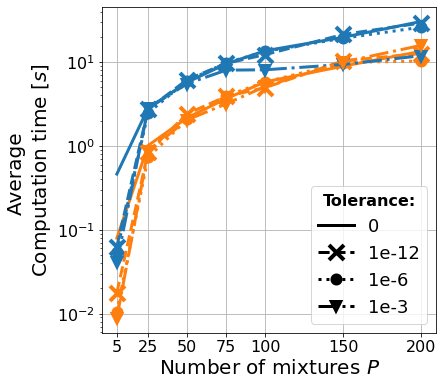

In [117]:
print(np.mean(QRT_time,axis=1),np.mean(FICA_time,axis=1))
linestyle='dashed'
FICA_p = {}; QRT_p = {}

marklist = ['None','x','o','v']
linestyleL = ['solid','dashed','dotted','dashdot']
sizeL = [0,15,8,8]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig,ax = plt.subplots(figsize=[6,6])
for t in range(len(Ltol)):
    i=t
    ax.set_xticks(Prange)
    plt.yticks(fontsize=16)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_xticklabels(Prange,fontsize=16)
    FICA_p[t], = plt.plot(Prange,np.mean(FICA_time[t,:,:].squeeze(),axis=1),label='FICA',linewidth=3,color=colors[0],linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i])
    # plt.fill_between(Prange,np.mean(FICA_time[t,:,:].squeeze(),axis=1)-np.std(FICA_time[t,:,:].squeeze(),axis=1),np.mean(FICA_time[t,:,:].squeeze(),axis=1)+np.std(FICA_time[t,:,:].squeeze(),axis=1),alpha=.3)
    QRT_p[t], = plt.plot(Prange,np.mean(QRT_time[t,:,:].squeeze(),axis=1),label='QRT',linewidth=3,color=colors[1],linestyle=linestyleL[i],marker=marklist[i],markeredgewidth=4,markersize=sizeL[i])
    # plt.fill_between(Prange,np.mean(QRT_time[t,:,:].squeeze(),axis=1)-np.std(QRT_time[t,:,:].squeeze(),axis=1),np.mean(QRT_time[t,:,:].squeeze(),axis=1)+np.std(QRT_time[t,:,:].squeeze(),axis=1),alpha=.3)
    plt.xlabel('Number of mixtures $P$',fontsize=20)
    plt.ylabel('Average \nComputation time $[s]$',fontsize=20)
    # plt.grid('on',which='minor',linewidth=3,color='k')
    # plt.grid('on',which='major')
    # plt.legend(fontsize=20,loc='upper left')
# plt.yscale('log')
plt.grid('on')


leg = plt.legend(handles=[FICA_p[0],FICA_p[1],FICA_p[2],FICA_p[3]],labels=['0','1e-12','1e-6','1e-3'],fontsize=18,loc='upper left')
title = leg.get_title()
leg.set_title('Tolerance:')
title.set_fontsize(16)
title.set_weight('bold')
handles = leg.legendHandles
handles[0].set_color('k')
handles[1].set_color('k')
handles[2].set_color('k')
handles[3].set_color('k')

## Plot error functions

This section contains the code used to plot a single or multiple averaged instances of the error of the QRT, fastICA and CP-fixed-point methods. It is used in the thesis to show how the CP-fixed-point converges better than QRT and FAstICA at higher values of P.

In [78]:
# PlusMinus method
n_repeat = 10
seed_seq = [*range(n_repeat)]

In [79]:
Prange = [*range(4,11)]
niter = 500; tol = 10**(-4)

fail_QRT = 1000*np.ones([len(Prange),n_repeat]); fail_FICA = 1000*np.ones([len(Prange),n_repeat]); fail_ffFICA = 1000*np.ones([len(Prange),n_repeat])
count_QRT = np.zeros(len(Prange)); count_FICA = np.zeros(len(Prange)); count_ffFICA = np.zeros(len(Prange))

err_QRT = np.zeros([len(Prange),n_repeat,niter])
err_FICA = np.zeros([len(Prange),n_repeat,niter])
err_ffFICA = np.zeros([len(Prange),n_repeat,niter])


for pr,prval in enumerate(Prange):
    print(pr)
    for i in range(n_repeat):
        #  Generate testdata with random mixing matrix
        P = prval
        R = P
        I = 10000
        noise_factor = 0.15 
        np.random.seed(seed_seq[i])

        start_end = [0,10]
        X,S,_,_ = mc.testset(P,I,noise_factor,start_end,random_mixmatrix=True)
        S_backup = np.copy(S)

        # Whiten data SVD
        _,_,Z = mc.SVDinit(X,R,removemean=True)
        Z_backup = np.copy(Z)

        # # QRT
        S_hat_QRT,U0,err_QRT[pr,i,:],_ = mc.QRT_FinalFAST(Z,R,np.eye(P),n_repeat=niter,tol=tol)
        dict_QRT = mc.Errorfunc(np.copy(S),S_hat_QRT)
        count_QRT[pr] += dict_QRT['succes']
        Z = np.copy(Z_backup)
        if dict_QRT['succes']== 0:
            fail_QRT[pr,i] = i

        # # FICA
        FICA = FastICA(whiten=False,max_iter=niter,w_init=np.eye(P),tol=tol,fun='cube')
        S_hat_FICA,err_FICA[pr,i,:] = FICA.fit_transform(Z.T); S_hat_FICA = S_hat_FICA.T
        dict_FICA = mc.Errorfunc(np.copy(S),S_hat_FICA)
        count_FICA[pr] += dict_FICA['succes']
        Z = np.copy(Z_backup)
        if dict_FICA['succes']== 0:
            fail_FICA[pr,i] = i

        # ffFICA method
        lam,U0,ffFICAniter,err_ffFICA[pr,i,:] = mc.symIMPCPDffWHITEFAST(np.copy(Z),np.ones(P),np.eye(P),P,niter,tol)
        S_hat_ffFICA = U0.T @ np.copy(Z)
        dict_ffFICA = mc.Errorfunc(np.copy(S),S_hat_ffFICA)
        count_ffFICA[pr] += dict_ffFICA['succes']
        Z = np.copy(Z_backup)
        if dict_ffFICA['succes']== 0:
            fail_ffFICA[pr,i] = i



0
1
2
3
4
5
6


c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\pierre-antoine\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:251: RuntimeWarning: invalid value encounte

Text(0.5, 0, 'Number of iterations $k$')

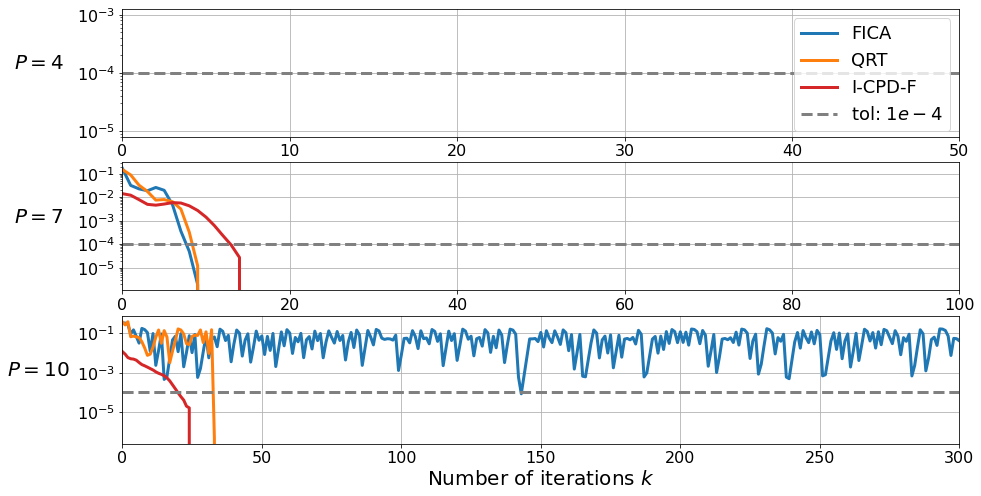

In [82]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
idx = 0
# plt.figure(figsize=[17,5])
plt.subplots(3,1,figsize=[15,8])
for val,i in enumerate([0,3,6]):
    ax = plt.subplot(3,1,val+1)
    i = val
    err_QRTP = np.mean(err_QRT[i,:,:],axis=0)
    err_FICAP = np.mean(err_FICA[i,:,:],axis=0)
    err_ffFICAP = np.mean(err_ffFICA[i,:,:],axis=0)

    err_QRTPstd = np.std(err_QRT[i,:,:],axis=0)
    err_FICAPstd = np.std(err_FICA[i,:,:],axis=0)
    err_ffFICAPstd = np.std(err_ffFICA[i,:,:],axis=0)

    err_QRTP = np.mean(np.copy(err_QRT[i])[np.copy(fail_QRT[i,:])==1000][:],axis=0)
    err_FICAP = np.mean(np.copy(err_FICA[i])[np.copy(fail_FICA[i,:])==1000][:],axis=0)
    err_ffFICAP = np.mean(np.copy(err_ffFICA[i])[np.copy(fail_ffFICA[i,:])==1000][:],axis=0)

    err_QRTPstd = np.std(np.copy(err_QRT[i])[np.copy(fail_QRT[i,:])==1000][:],axis=0)
    err_FICAPstd = np.std(np.copy(err_FICA[i])[np.copy(fail_FICA[i,:])==1000][:],axis=0)
    err_ffFICAPstd = np.std(np.copy(err_ffFICA[i])[np.copy(fail_ffFICA[i,:])==1000][:],axis=0)


    r1 = 0; r2 = [50,100,300]
    plt.yticks([0.1,0.0001],labels=[0.1,0.0001],fontsize=16)
    plt.xlim([0,r2[val]])

    plt.plot(range(500),err_FICAP,color=colors[0],linewidth=3,label='FICA')
    plt.plot(range(500),err_QRTP,color=colors[1],linewidth=3,label='QRT')
    plt.plot(range(500),err_ffFICAP,color=colors[3],linewidth=3,label='I-CPD-F')

    # plt.plot(range(500),err_FICA[i,idx,:],color=colors[0],linewidth=3,label='FICA')
    # plt.plot(range(500),err_QRT[i,idx,:],color=colors[1],linewidth=3,label='QRT')
    # plt.plot(range(500),err_ffFICA[i,idx,:],color=colors[3],linewidth=3,label='I-CPD-F')
    plt.plot(tol*np.ones(500),linestyle='dashed',color='gray',linewidth=3,label='tol: $1e-4$')
    plt.grid('on')
    plt.yscale('log')
    if val ==0:
        plt.legend(fontsize=18)

    plt.xticks(fontsize=16)
    ylabels = ['$P=4$','$P=7$','$P=10$']
    plt.ylabel(ylabels[val],fontsize=20,rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.5)
plt.xlabel('Number of iterations $k$',fontsize=20)

